In [1]:
import pandas as pd
import numpy as np
import pm4py
print(pm4py.__version__)
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.algo.filtering.log.attributes import attributes_filter

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

2.7.13.1


# 데이터 확인

In [36]:
base_df = pd.read_csv("./repair2.csv")
base_df

caseID              taskID originator eventtype contact RepairType  \
0         419  InformClientSurvey     System  complete     NaN        NaN   
1         561       ArrangeSurvey     Monica  complete     NaN        NaN   
2         902   ReadyInformClient     System  complete     NaN        NaN   
3          18              Survey        Edd     start     NaN        NaN   
4         852              Survey        Edd  complete     NaN        NaN   
...       ...                 ...        ...       ...     ...        ...   
13257     707       ArrangeSurvey       Dian  complete     NaN        NaN   
13258      25       ArrangeSurvey       Dian     start     NaN        NaN   
13259     762       ArrangeSurvey     Monica     start     NaN        NaN   
13260      12        InternRepair      Cindy     start     NaN        NaN   
13261     542        FirstContact     Monica  complete     Web        NaN   

       objectKey RepairInternally  EstimatedRepairTime  RepairCode RepairOK  \
0            NaN              NaN                  NaN         NaN      NaN   
1            NaN              NaN                  NaN         NaN      NaN   
2            NaN              NaN                  NaN         NaN     True   
3            NaN              NaN                  NaN         NaN      NaN   
4            NaN             True                240.0         1.0      NaN   
...          ...              ...                  ...         ...      ...   
13257        NaN              NaN                  NaN         NaN      NaN   
13258        NaN              NaN                  NaN         NaN      NaN   
13259        NaN              NaN                  NaN         NaN      NaN   
13260        NaN              NaN                  NaN         NaN      NaN   
13261        NaN              NaN                  NaN         NaN      NaN   

             date   time  
0      2020-01-06  11:51  
1      2020-01-07  13:48  
2      2020-01-08  16:20  
3      2020-01-09   6:55  
4      2020-01-10  11:33  
...           ...    ...  
13257  1970-01-07   0:16  
13258  1970-01-02   7:48  
13259  1970-01-03  11:53  
13260  1970-01-08  18:10  
13261  1970-01-02  16:33  

[13262 rows x 13 columns]

In [37]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13262 entries, 0 to 13261
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   caseID               13262 non-null  int64  
 1   taskID               13260 non-null  object 
 2   originator           13260 non-null  object 
 3   eventtype            13257 non-null  object 
 4   contact              1000 non-null   object 
 5   RepairType           927 non-null    object 
 6   objectKey            927 non-null    float64
 7   RepairInternally     927 non-null    object 
 8   EstimatedRepairTime  927 non-null    float64
 9   RepairCode           927 non-null    float64
 10  RepairOK             1854 non-null   object 
 11  date                 13249 non-null  object 
 12  time                 13249 non-null  object 
dtypes: float64(3), int64(1), object(9)
memory usage: 1.3+ MB


In [38]:
base_df.isnull().sum()

caseID                     0
taskID                     2
originator                 2
eventtype                  5
contact                12262
RepairType             12335
objectKey              12335
RepairInternally       12335
EstimatedRepairTime    12335
RepairCode             12335
RepairOK               11408
date                      13
time                      13
dtype: int64

In [39]:
print(list(base_df['date'].value_counts().index))

['1970-01-07', '1970-01-04', '1970-01-05', '1970-01-03', '1970-01-02', '1970-01-06', '1970-01-08', '1970-01-01', '1970-01-13', '1970-01-12', '1970-01-10', '1970-01-09', '1970-01-11', '1970-01-14', '1970-01-16', '1970-01-15', '1970-01-17', '1970-01-18', '1970-01-19', '1970-01-20', '1905-05-23', '2021-08-13', '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07', '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11', '2021-08-12', '2021-08-23', '2021-08-14', '2021-08-15', '2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19', '2021-08-20', '2021-08-21', '2021-08-22', '2021-07-31', '2021-08-24', '2021-08-01', '2021-07-21', '2021-07-30', '2021-07-17', '2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10', '2021-07-11', '2021-07-12', '2021-07-13', '2021-07-14', '2021-07-15', '2021-07-16', '2021-07-18', '2021-07-29', '2021-07-19', '2021-07-20', '2021-08-26', '2021-07-22', '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26', '2021-07-27', '2021-07-28', '2021

날짜 분포 확인

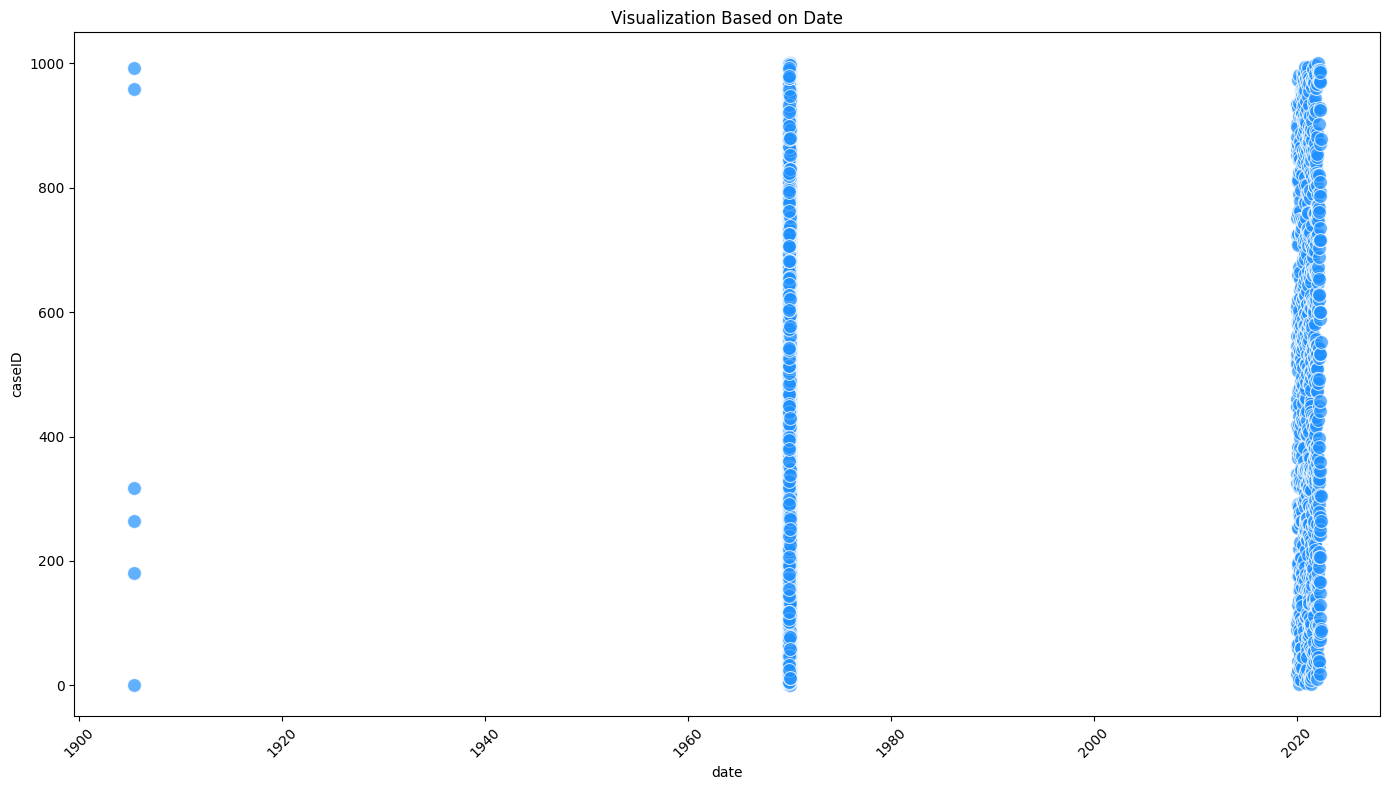

In [40]:
base_df['date'] = pd.to_datetime(base_df['date'], errors='coerce')

case_date = base_df[['caseID', 'date']]

plt.figure(figsize=(14, 8))
sns.scatterplot(x='date', y='caseID', data=case_date, s=100, alpha=0.7, color='#1E90FF')

plt.title('Visualization Based on Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 전처리

날짜 전처리

In [41]:
data = base_df[base_df['date'] > '1971-01-01']
data

caseID              taskID originator eventtype contact RepairType  \
0       419  InformClientSurvey     System  complete     NaN        NaN   
1       561       ArrangeSurvey     Monica  complete     NaN        NaN   
2       902   ReadyInformClient     System  complete     NaN        NaN   
3        18              Survey        Edd     start     NaN        NaN   
4       852              Survey        Edd  complete     NaN        NaN   
..      ...                 ...        ...       ...     ...        ...   
855      90  InformClientSurvey     System  complete     NaN        NaN   
856     304         TicketReady     System  complete     NaN        NaN   
857     264        FirstContact     Monica  complete   Phone        NaN   
858      87          MakeTicket       Dian  complete     NaN          P   
859     552        InternRepair        Lex     start     NaN        NaN   

     objectKey RepairInternally  EstimatedRepairTime  RepairCode RepairOK  \
0          NaN              NaN                  NaN         NaN      NaN   
1          NaN              NaN                  NaN         NaN      NaN   
2          NaN              NaN                  NaN         NaN     True   
3          NaN              NaN                  NaN         NaN      NaN   
4          NaN             True                240.0         1.0      NaN   
..         ...              ...                  ...         ...      ...   
855        NaN              NaN                  NaN         NaN      NaN   
856        NaN              NaN                  NaN         NaN      NaN   
857        NaN              NaN                  NaN         NaN      NaN   
858     5525.0              NaN                  NaN         NaN      NaN   
859        NaN              NaN                  NaN         NaN      NaN   

          date   time  
0   2020-01-06  11:51  
1   2020-01-07  13:48  
2   2020-01-08  16:20  
3   2020-01-09   6:55  
4   2020-01-10  11:33  
..         ...    ...  
855 2022-05-10  10:19  
856 2022-05-11  20:00  
857 2022-05-12   6:42  
858 2022-05-13  21:05  
859 2022-05-14   4:48  

[860 rows x 13 columns]

In [42]:
data.isnull().sum()

caseID                   0
taskID                   0
originator               0
eventtype                0
contact                809
RepairType             786
objectKey              786
RepairInternally       802
EstimatedRepairTime    802
RepairCode             802
RepairOK               738
date                     0
time                     0
dtype: int64

In [43]:
#날짜 전처리 : 날짜와 시간으로 나뉘어 있던 데이터를 하나의 열로 통합한 후, datetime 타입으로 변환
data['datetime'] = pd.to_datetime(data['date'].astype(str) + ' ' + data['time'])
data = data.drop(['date', 'time'], axis=1)

In [44]:
data

caseID              taskID originator eventtype contact RepairType  \
0       419  InformClientSurvey     System  complete     NaN        NaN   
1       561       ArrangeSurvey     Monica  complete     NaN        NaN   
2       902   ReadyInformClient     System  complete     NaN        NaN   
3        18              Survey        Edd     start     NaN        NaN   
4       852              Survey        Edd  complete     NaN        NaN   
..      ...                 ...        ...       ...     ...        ...   
855      90  InformClientSurvey     System  complete     NaN        NaN   
856     304         TicketReady     System  complete     NaN        NaN   
857     264        FirstContact     Monica  complete   Phone        NaN   
858      87          MakeTicket       Dian  complete     NaN          P   
859     552        InternRepair        Lex     start     NaN        NaN   

     objectKey RepairInternally  EstimatedRepairTime  RepairCode RepairOK  \
0          NaN              NaN                  NaN         NaN      NaN   
1          NaN              NaN                  NaN         NaN      NaN   
2          NaN              NaN                  NaN         NaN     True   
3          NaN              NaN                  NaN         NaN      NaN   
4          NaN             True                240.0         1.0      NaN   
..         ...              ...                  ...         ...      ...   
855        NaN              NaN                  NaN         NaN      NaN   
856        NaN              NaN                  NaN         NaN      NaN   
857        NaN              NaN                  NaN         NaN      NaN   
858     5525.0              NaN                  NaN         NaN      NaN   
859        NaN              NaN                  NaN         NaN      NaN   

               datetime  
0   2020-01-06 11:51:00  
1   2020-01-07 13:48:00  
2   2020-01-08 16:20:00  
3   2020-01-09 06:55:00  
4   2020-01-10 11:33:00  
..                  ...  
855 2022-05-10 10:19:00  
856 2022-05-11 20:00:00  
857 2022-05-12 06:42:00  
858 2022-05-13 21:05:00  
859 2022-05-14 04:48:00  

[860 rows x 12 columns]

RepairCode type 전처리 : 수치형인 RepairCode를 범주형으로 변환하기 위해 str타입으로 변환

In [45]:
data['RepairCode']=data['RepairCode'].astype(str)

# 데이터 기초통계

In [46]:
data[['taskID','originator','eventtype','contact',
     'RepairType','RepairInternally','RepairCode',
     'RepairOK']].describe()

taskID originator eventtype contact RepairType RepairInternally  \
count          860        860       860      51         74               58   
unique          13         16         2       4          3                2   
top     MakeTicket     System  complete   Phone          P             True   
freq           132        294       609      19         38               55   

       RepairCode RepairOK  
count         860      122  
unique          5        1  
top           nan     True  
freq          802      122

In [47]:
print(np.unique(data['taskID']))
# 총 13개의 값이 존재, 각 값은 수리 과정에서 수행된 업무(task)

['ArrangeSurvey' 'ExternRepair' 'FirstContact' 'ImmediateRepair'
 'InformClientSurvey' 'InformClientWrongPlace' 'InternRepair' 'MakeTicket'
 'ReadyInformClient' 'RepairReady' 'SendTicketToFinAdmin' 'Survey'
 'TicketReady']


In [48]:
data['RepairOK'].value_counts()

True    122
Name: RepairOK, dtype: int64

## 시각화

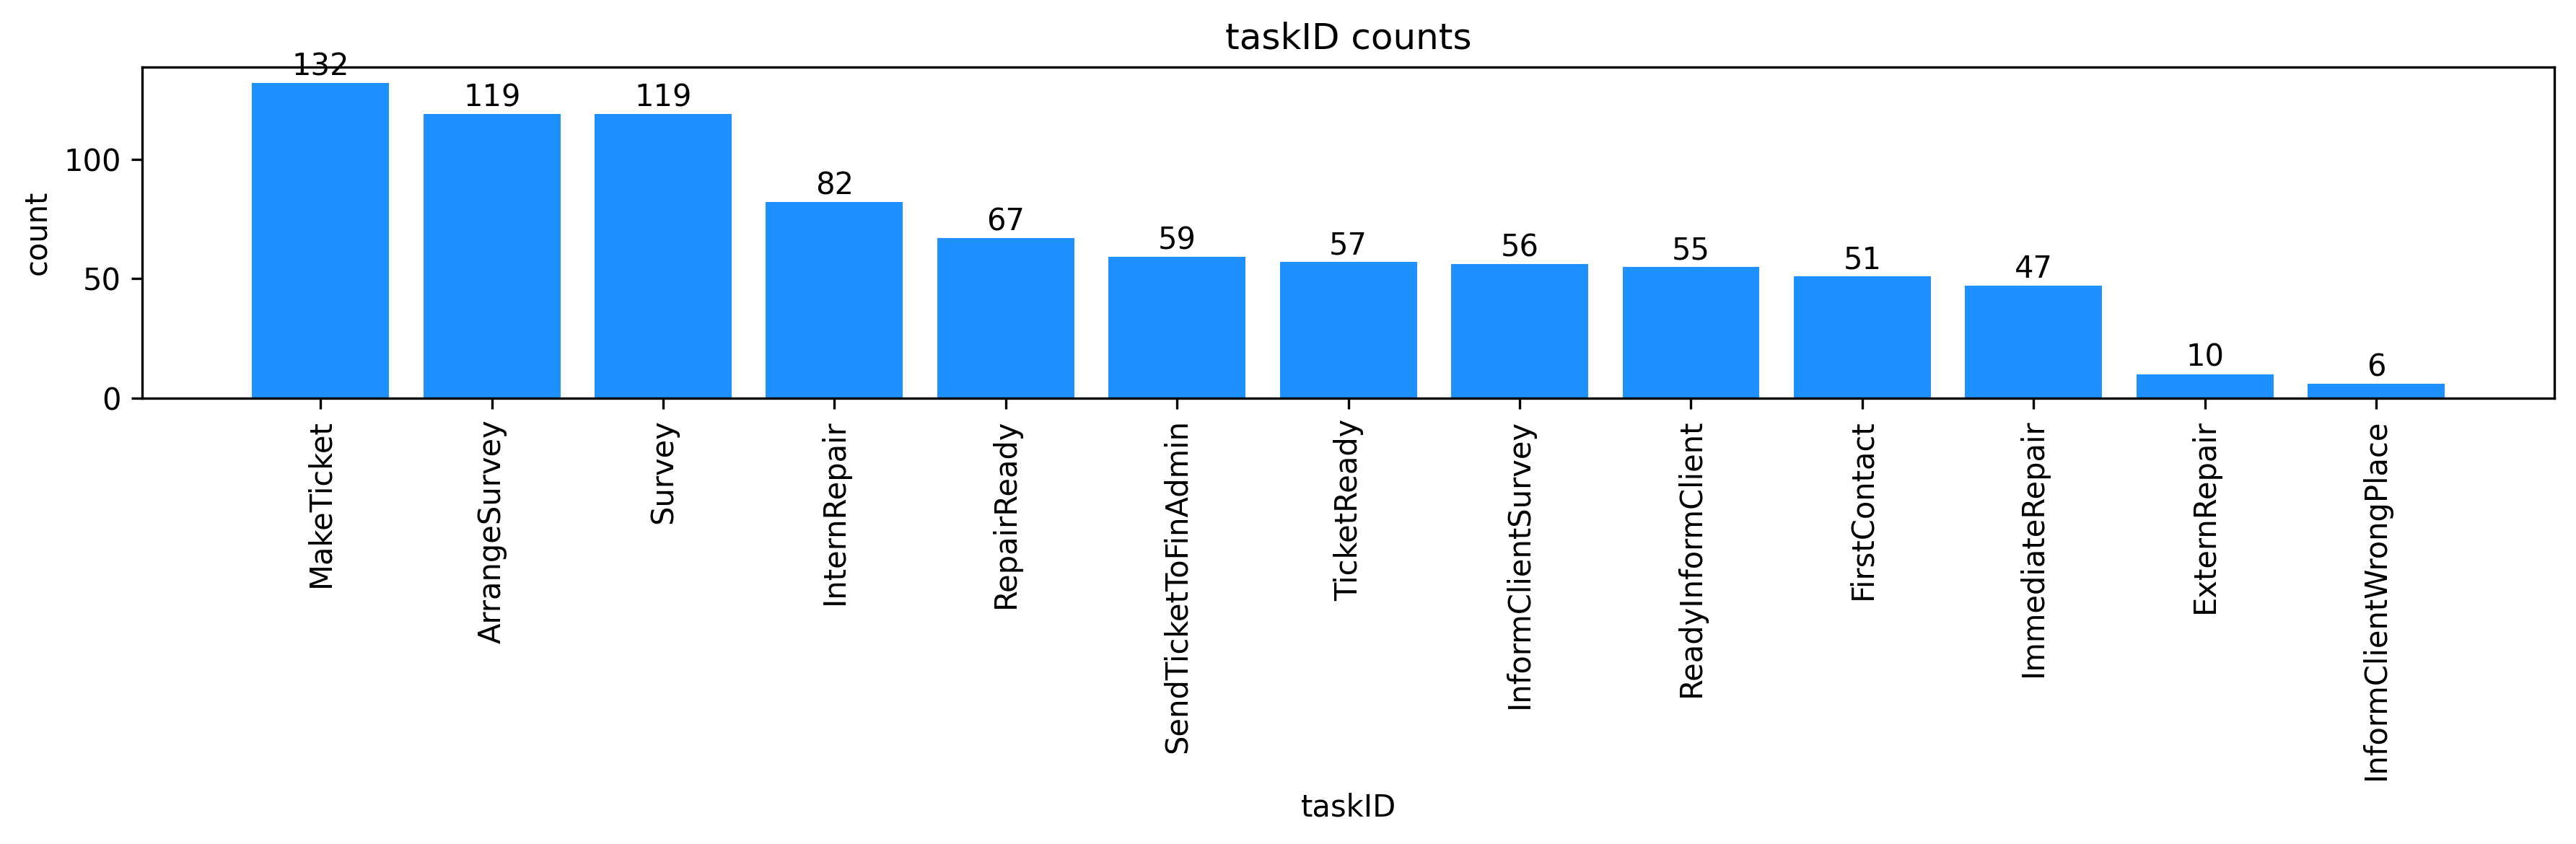

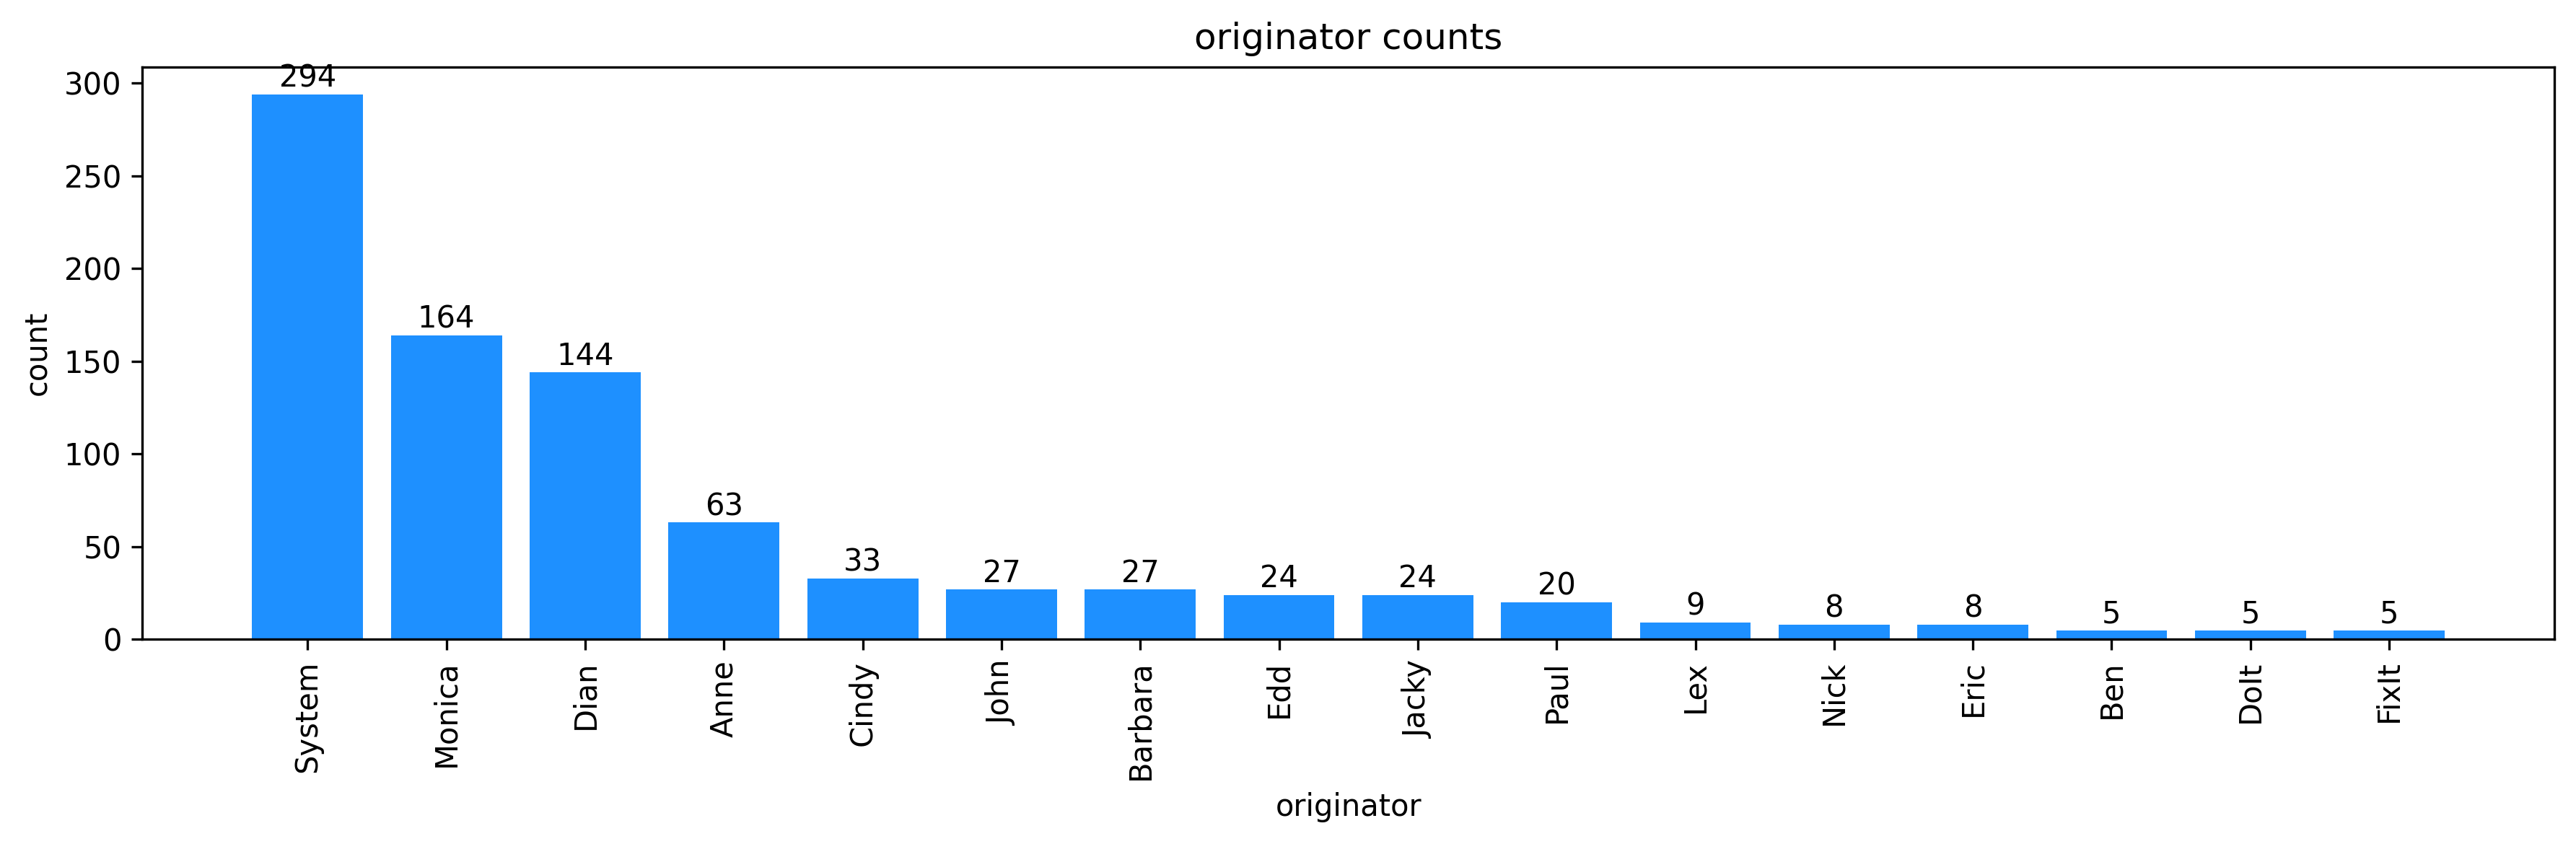

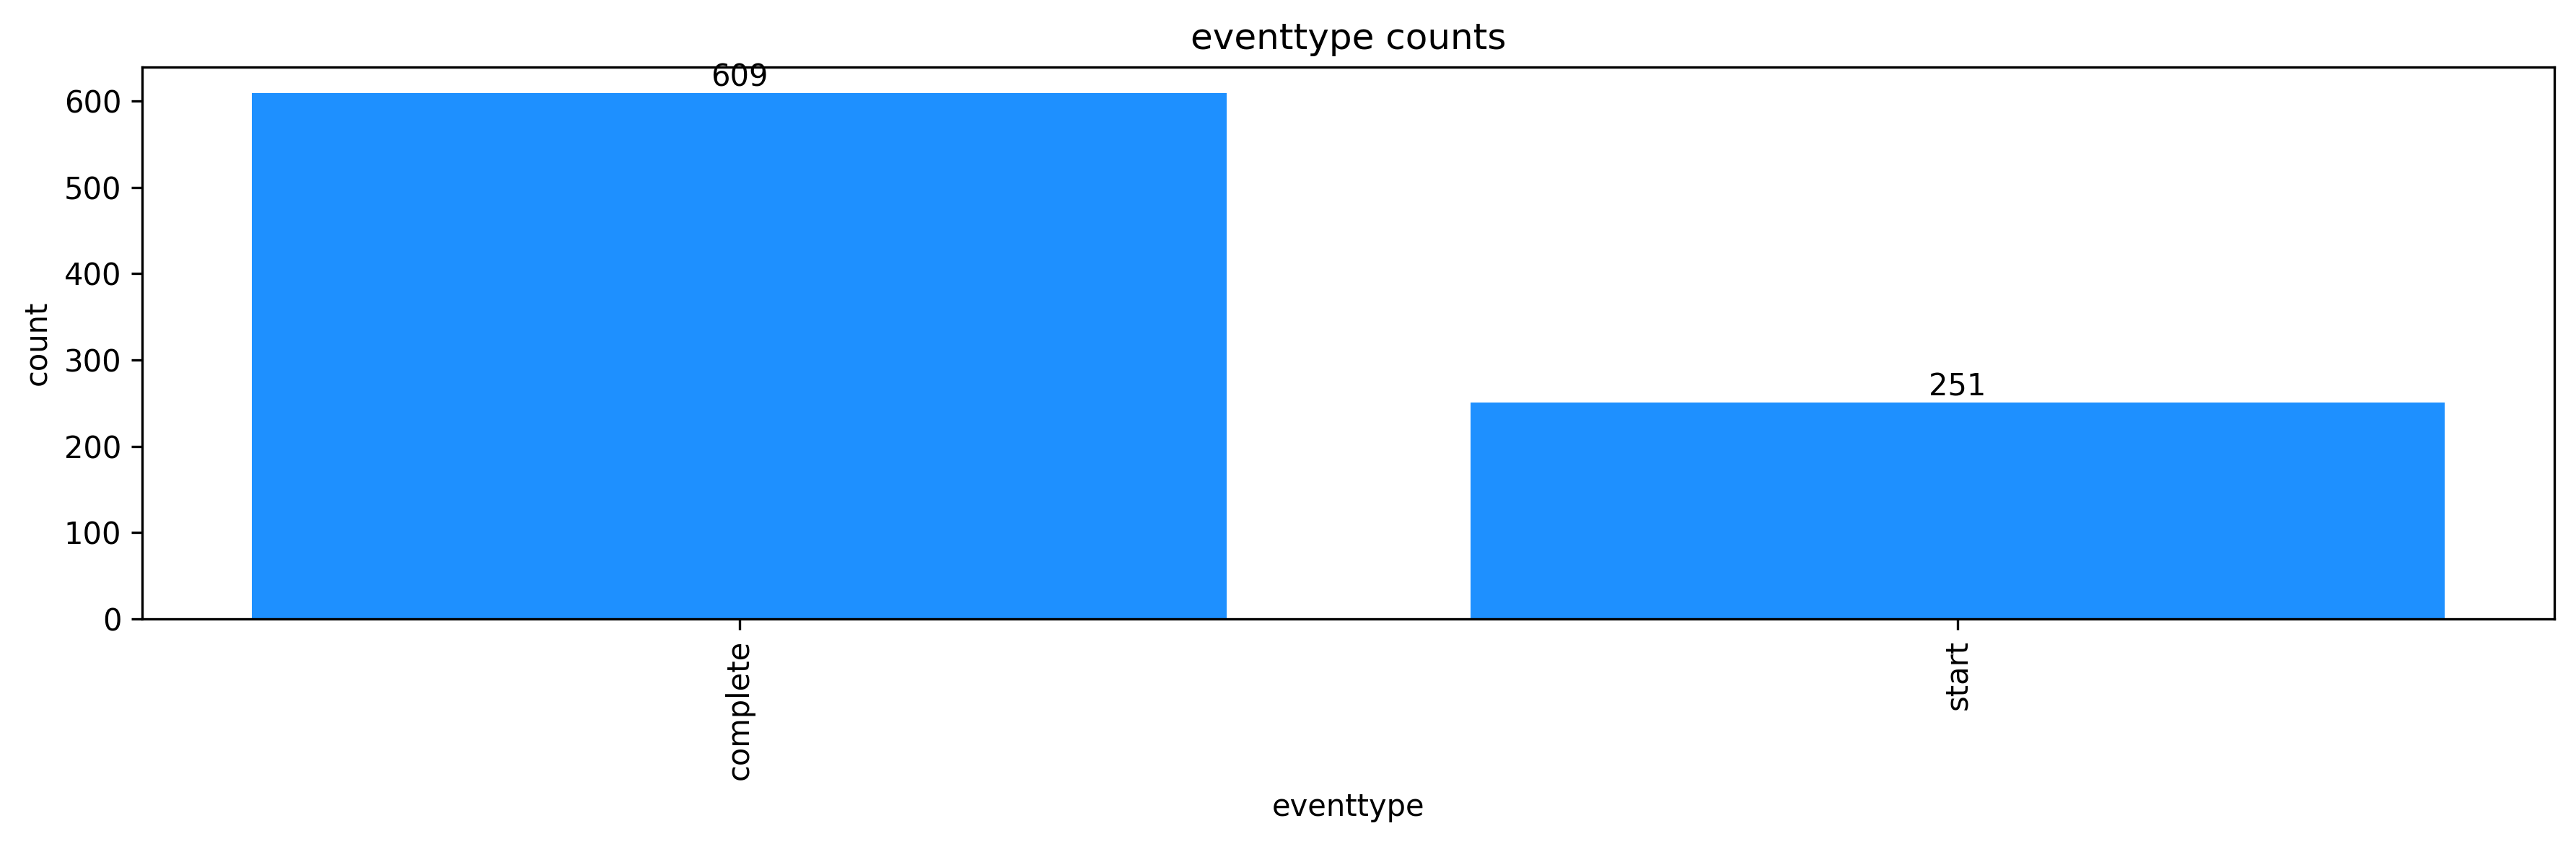

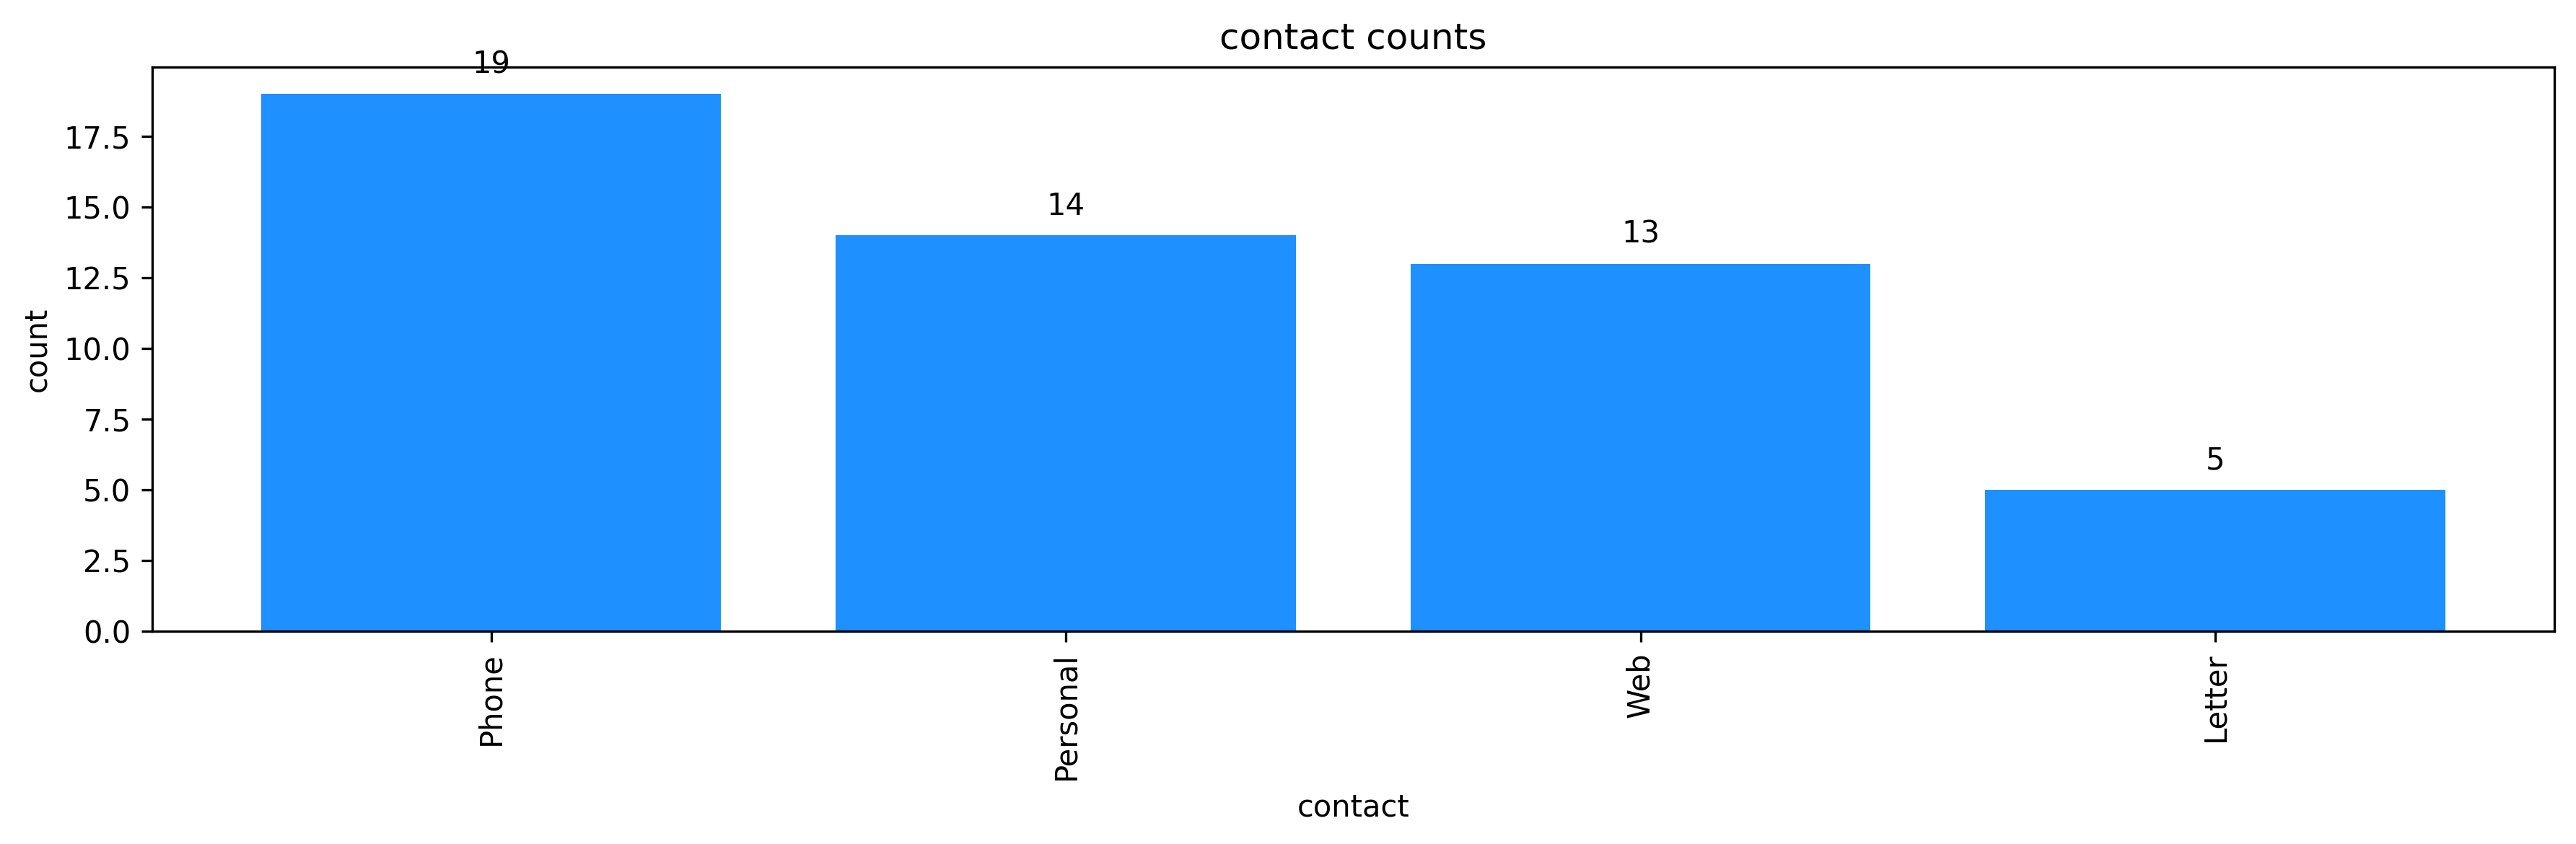

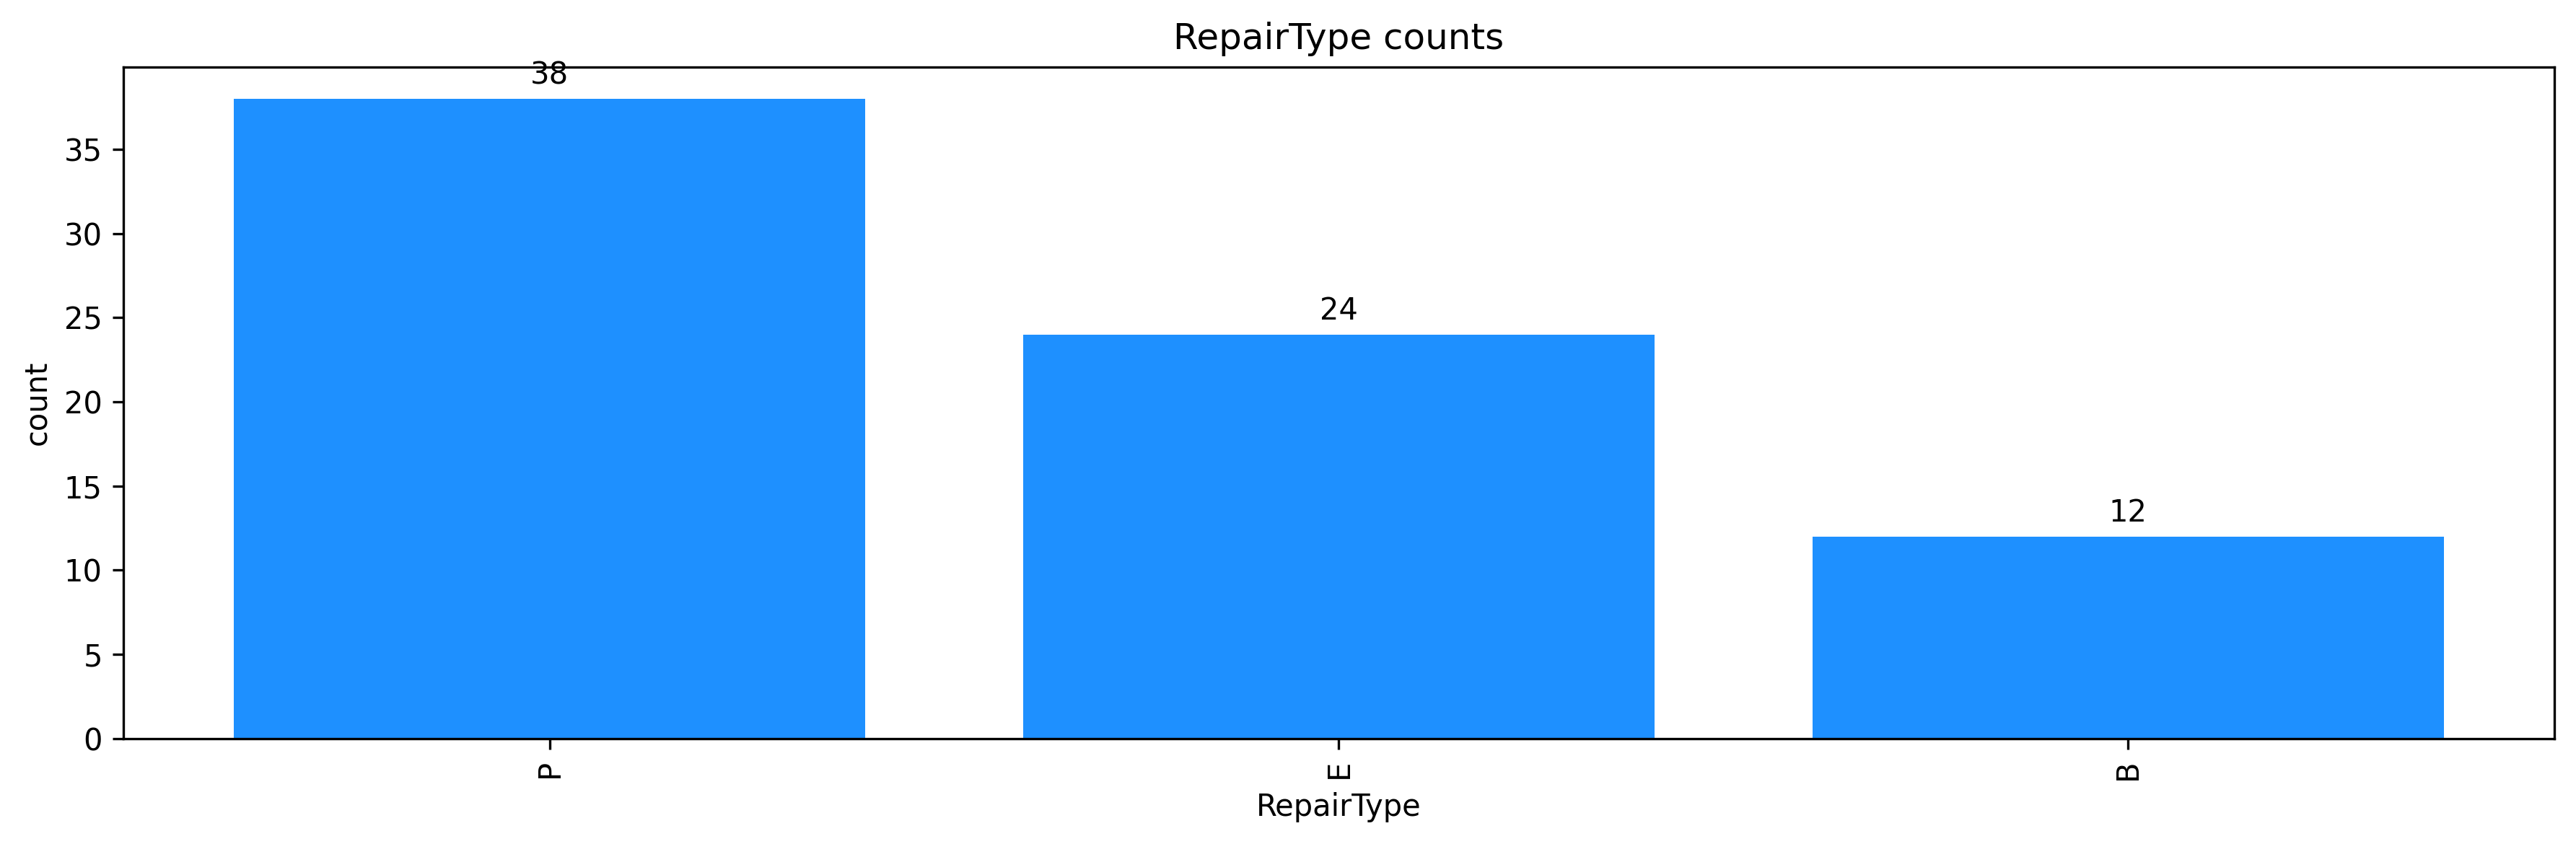

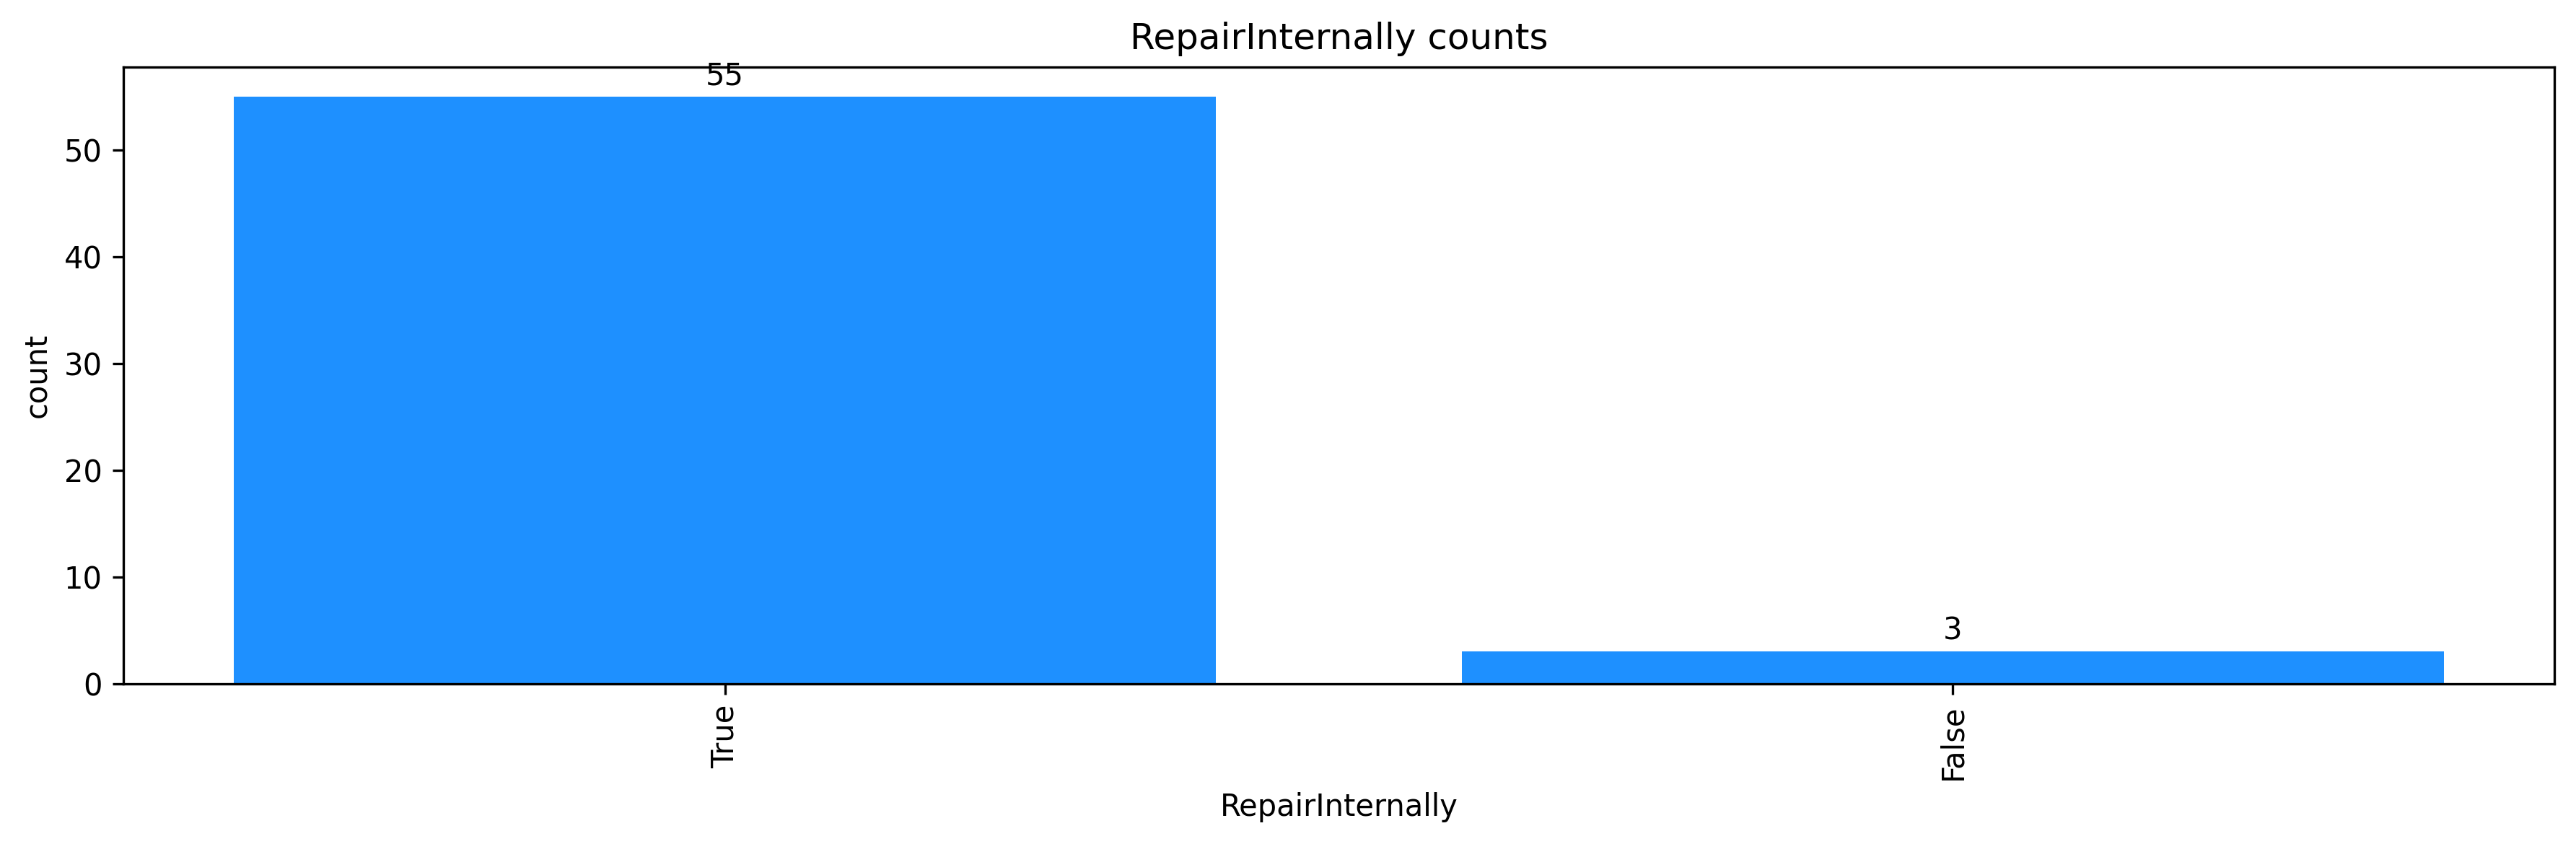

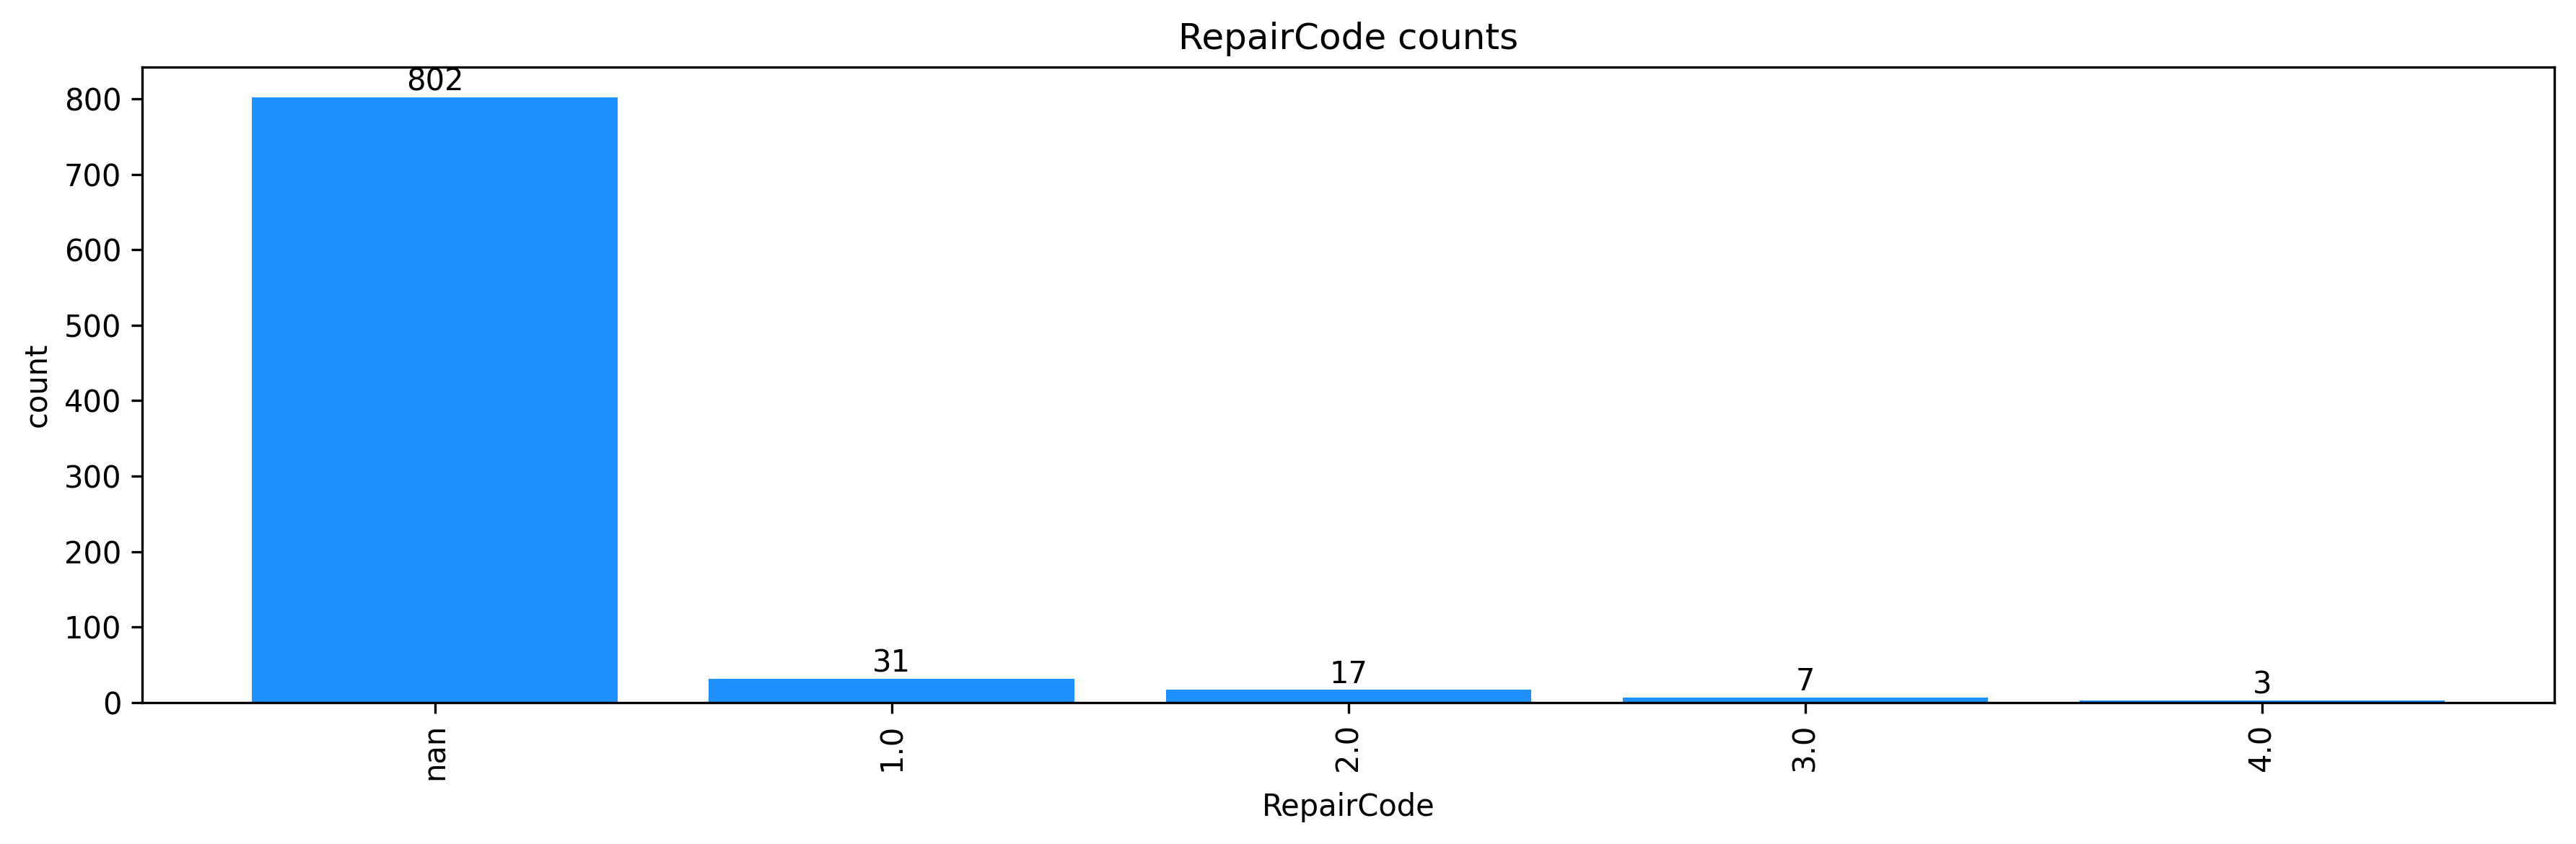

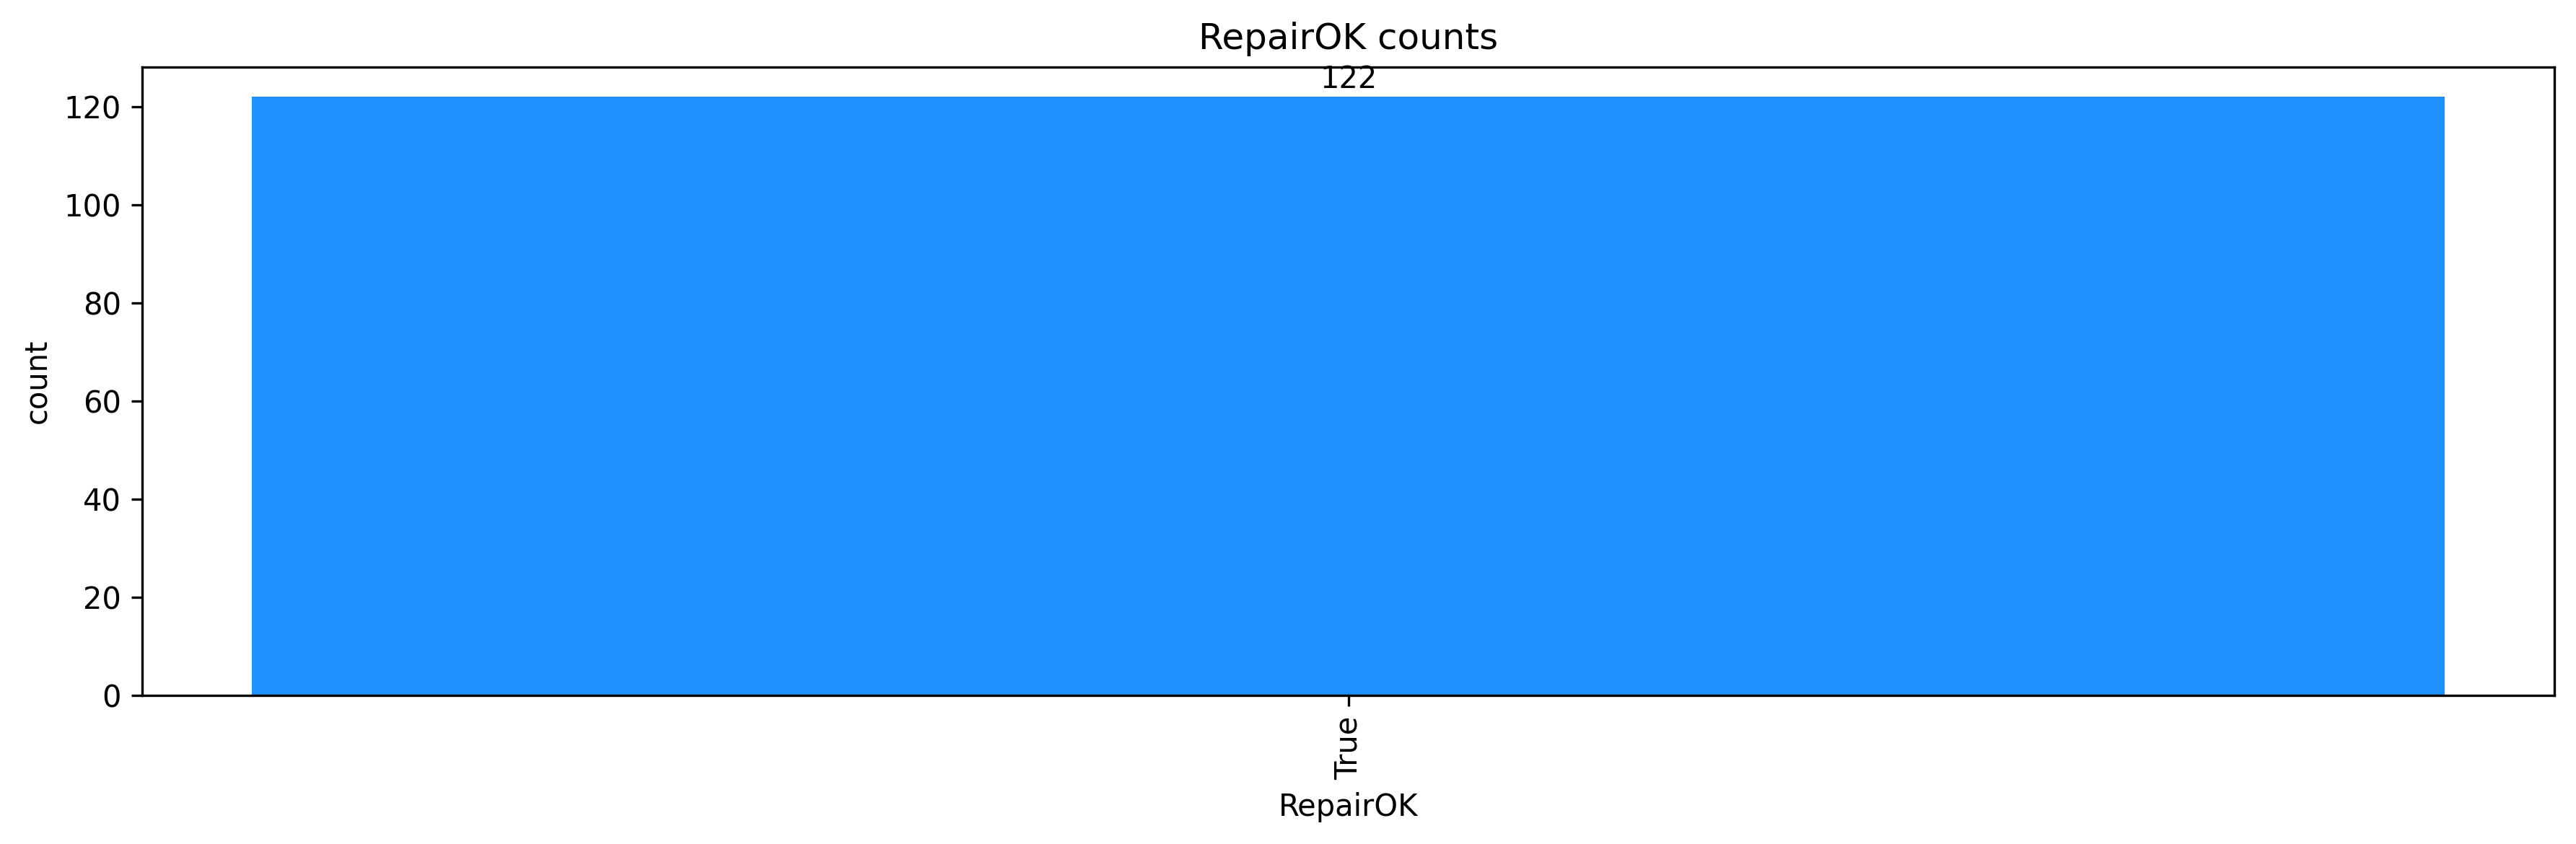

In [49]:
columns = ['taskID', 'originator', 'eventtype', 'contact', 'RepairType', 'RepairInternally', 'RepairCode', 'RepairOK']

for col in columns:
    value_counts = data[col].value_counts()

    fig, ax = plt.subplots(figsize=(12, 4), dpi=300)
    bars = ax.bar(value_counts.index.astype(str), value_counts.values, color='#1E90FF')  

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, yval, ha='center', va='bottom', fontsize=10)

    ax.set_title(f'{col} counts')
    ax.set_xlabel(col)
    ax.set_ylabel('count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


# 프로세스 분석

In [50]:
data = data.rename(columns={'caseID': 'case:concept:name', 'taskID': 'concept:name', 'datetime': 'time:timestamp'})
data['time:timestamp'] = pd.to_datetime(data['time:timestamp'])
event_log = log_converter.apply(data)

In [51]:
event_log

[{'attributes': {'concept:name': 419}, 'events': [{'concept:name': 'InformClientSurvey', 'originator': 'System', 'eventtype': 'complete', 'contact': nan, 'RepairType': nan, 'objectKey': nan, 'RepairInternally': nan, 'EstimatedRepairTime': nan, 'RepairCode': 'nan', 'RepairOK': nan, 'time:timestamp': Timestamp('2020-01-06 11:51:00')}]}, '....', {'attributes': {'concept:name': 87}, 'events': [{'concept:name': 'MakeTicket', 'originator': 'Dian', 'eventtype': 'complete', 'contact': nan, 'RepairType': 'P', 'objectKey': 5525.0, 'RepairInternally': nan, 'EstimatedRepairTime': nan, 'RepairCode': 'nan', 'RepairOK': nan, 'time:timestamp': Timestamp('2022-05-13 21:05:00')}]}]

## Start & End Activities

In [52]:
def get_start_activities(log):
    start_acts = {}
    for trace in log:
        if trace:
            start_act = trace[0]['concept:name']
            if start_act in start_acts:
                start_acts[start_act] += 1
            else:
                start_acts[start_act] = 1
    return start_acts

def get_end_activities(log):
    end_acts = {}
    for trace in log:
        if trace:
            end_act = trace[-1]['concept:name']
            if end_act in end_acts:
                end_acts[end_act] += 1
            else:
                end_acts[end_act] = 1
    return end_acts
# 시작활동
start_activities = get_start_activities(event_log)
print("시작 활동 및 빈도", start_activities)

# 종료활동
end_activities = get_end_activities(event_log)
print("종료 활동 및 빈도", end_activities)

시작 활동 및 빈도 {'InformClientSurvey': 39, 'ArrangeSurvey': 83, 'ReadyInformClient': 37, 'Survey': 77, 'TicketReady': 41, 'MakeTicket': 92, 'InternRepair': 56, 'FirstContact': 37, 'RepairReady': 49, 'SendTicketToFinAdmin': 40, 'InformClientWrongPlace': 6, 'ImmediateRepair': 28, 'ExternRepair': 7}
종료 활동 및 빈도 {'InformClientSurvey': 41, 'MakeTicket': 85, 'ArrangeSurvey': 79, 'SendTicketToFinAdmin': 44, 'Survey': 82, 'TicketReady': 37, 'InternRepair': 52, 'FirstContact': 38, 'ImmediateRepair': 38, 'InformClientWrongPlace': 6, 'RepairReady': 46, 'ReadyInformClient': 35, 'ExternRepair': 9}


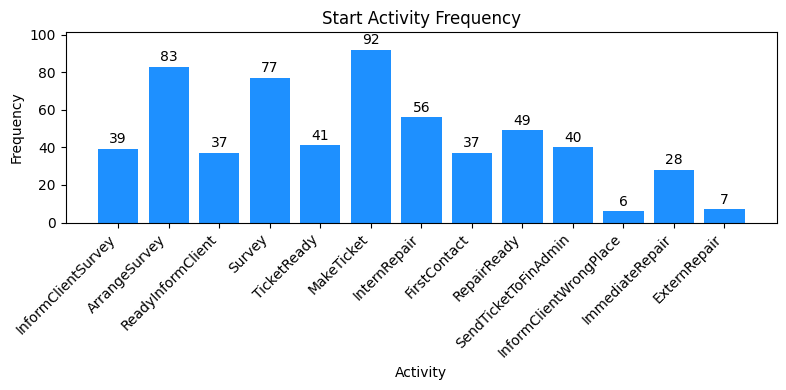

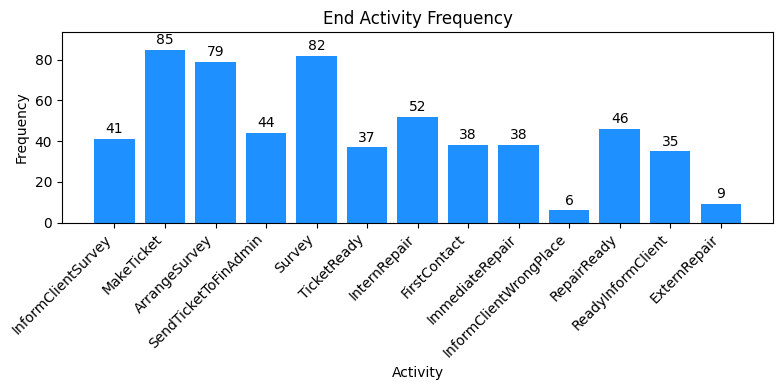

In [19]:
def plot_bar_chart(activity_dict, title):
    activities = list(activity_dict.keys())
    counts = list(activity_dict.values())
    
    plt.figure(figsize=(8, 4))
    bars = plt.bar(activities, counts, color='#1E90FF')
    plt.title(title)
    plt.xlabel('Activity')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 2),
                     textcoords="offset points",
                     ha='center', va='bottom',
                     clip_on=False)
    
    plt.ylim(top=max(counts) * 1.1)
    plt.tight_layout()
    plt.show()

plot_bar_chart(start_activities, "Start Activity Frequency")
plot_bar_chart(end_activities, "End Activity Frequency")


## Alpha 알고리즘

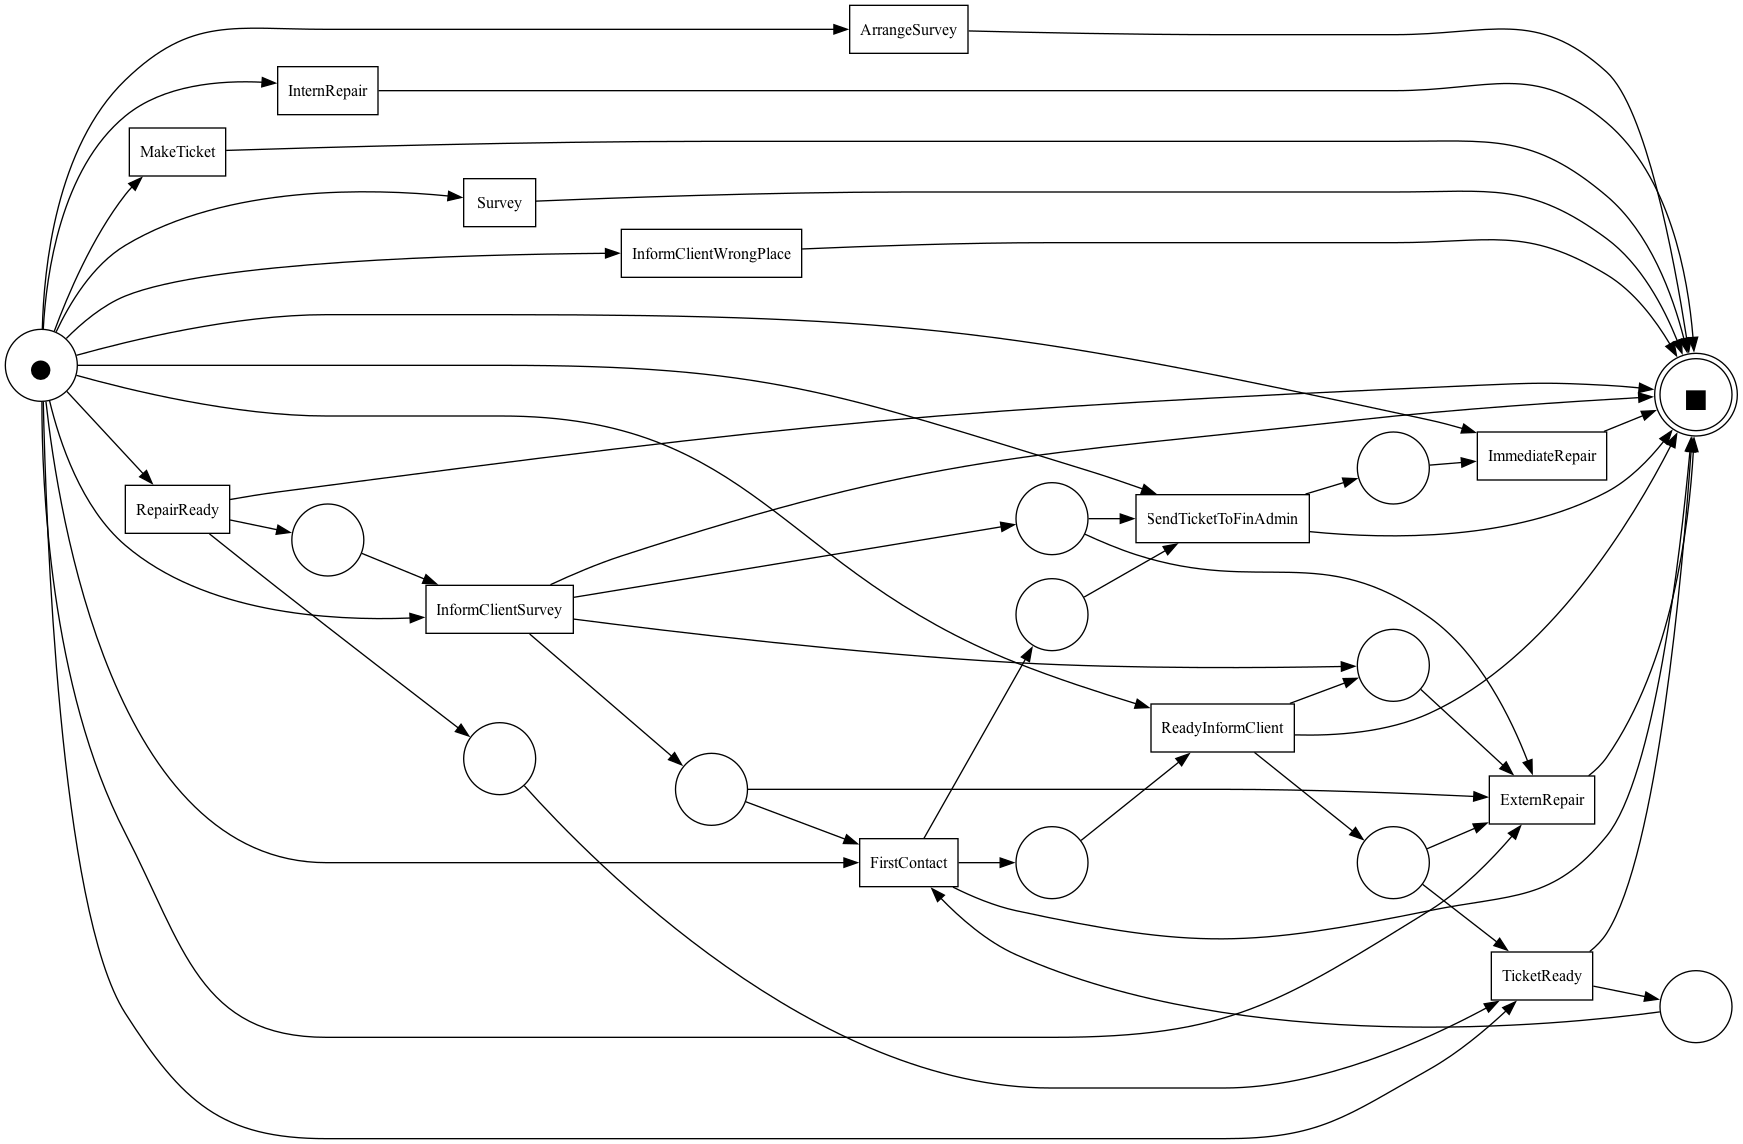

In [53]:
#Alpha 알고리즘을 사용하여 Petri 네트워크를 생성
net, initial_marking, final_marking = alpha_miner.apply(event_log)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

## Heuristic Mining 알고리즘

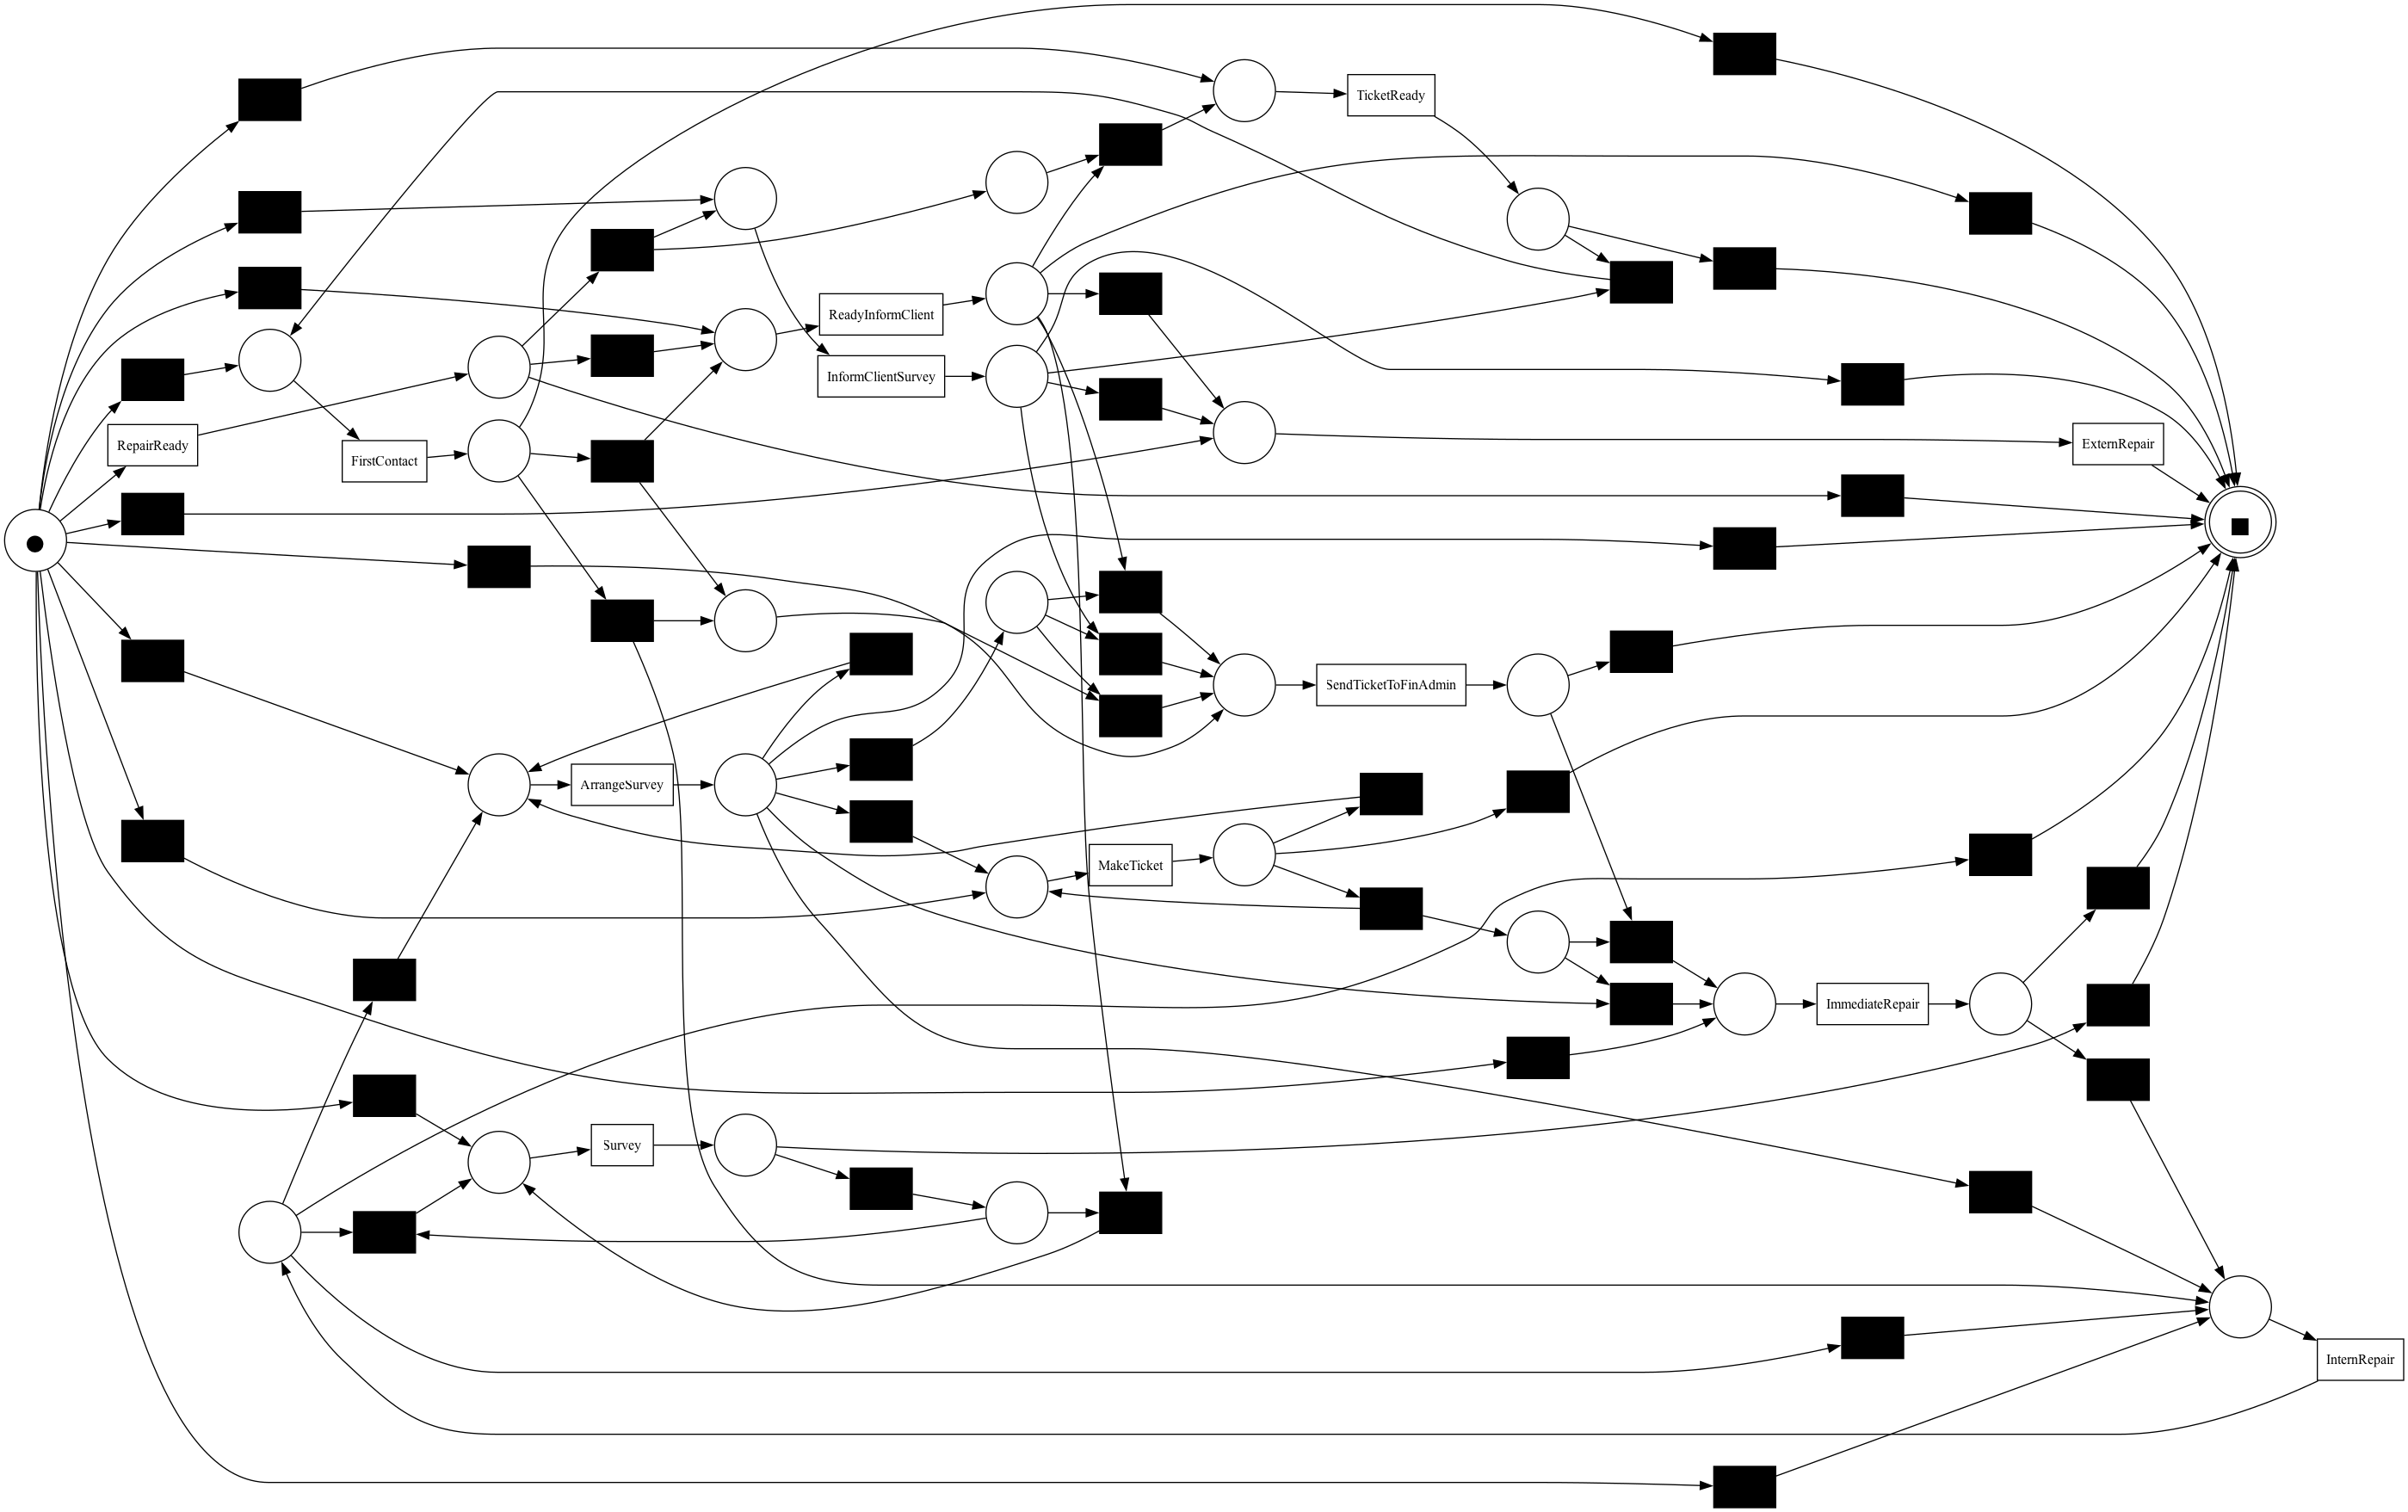

In [54]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner

net_heuristic, initial_marking_heuristic, final_marking_heuristic = heuristics_miner.apply(event_log)
gviz_heuristic = pn_visualizer.apply(net_heuristic, initial_marking_heuristic, final_marking_heuristic)
pn_visualizer.view(gviz_heuristic)

## Inductive Miner 알고리즘

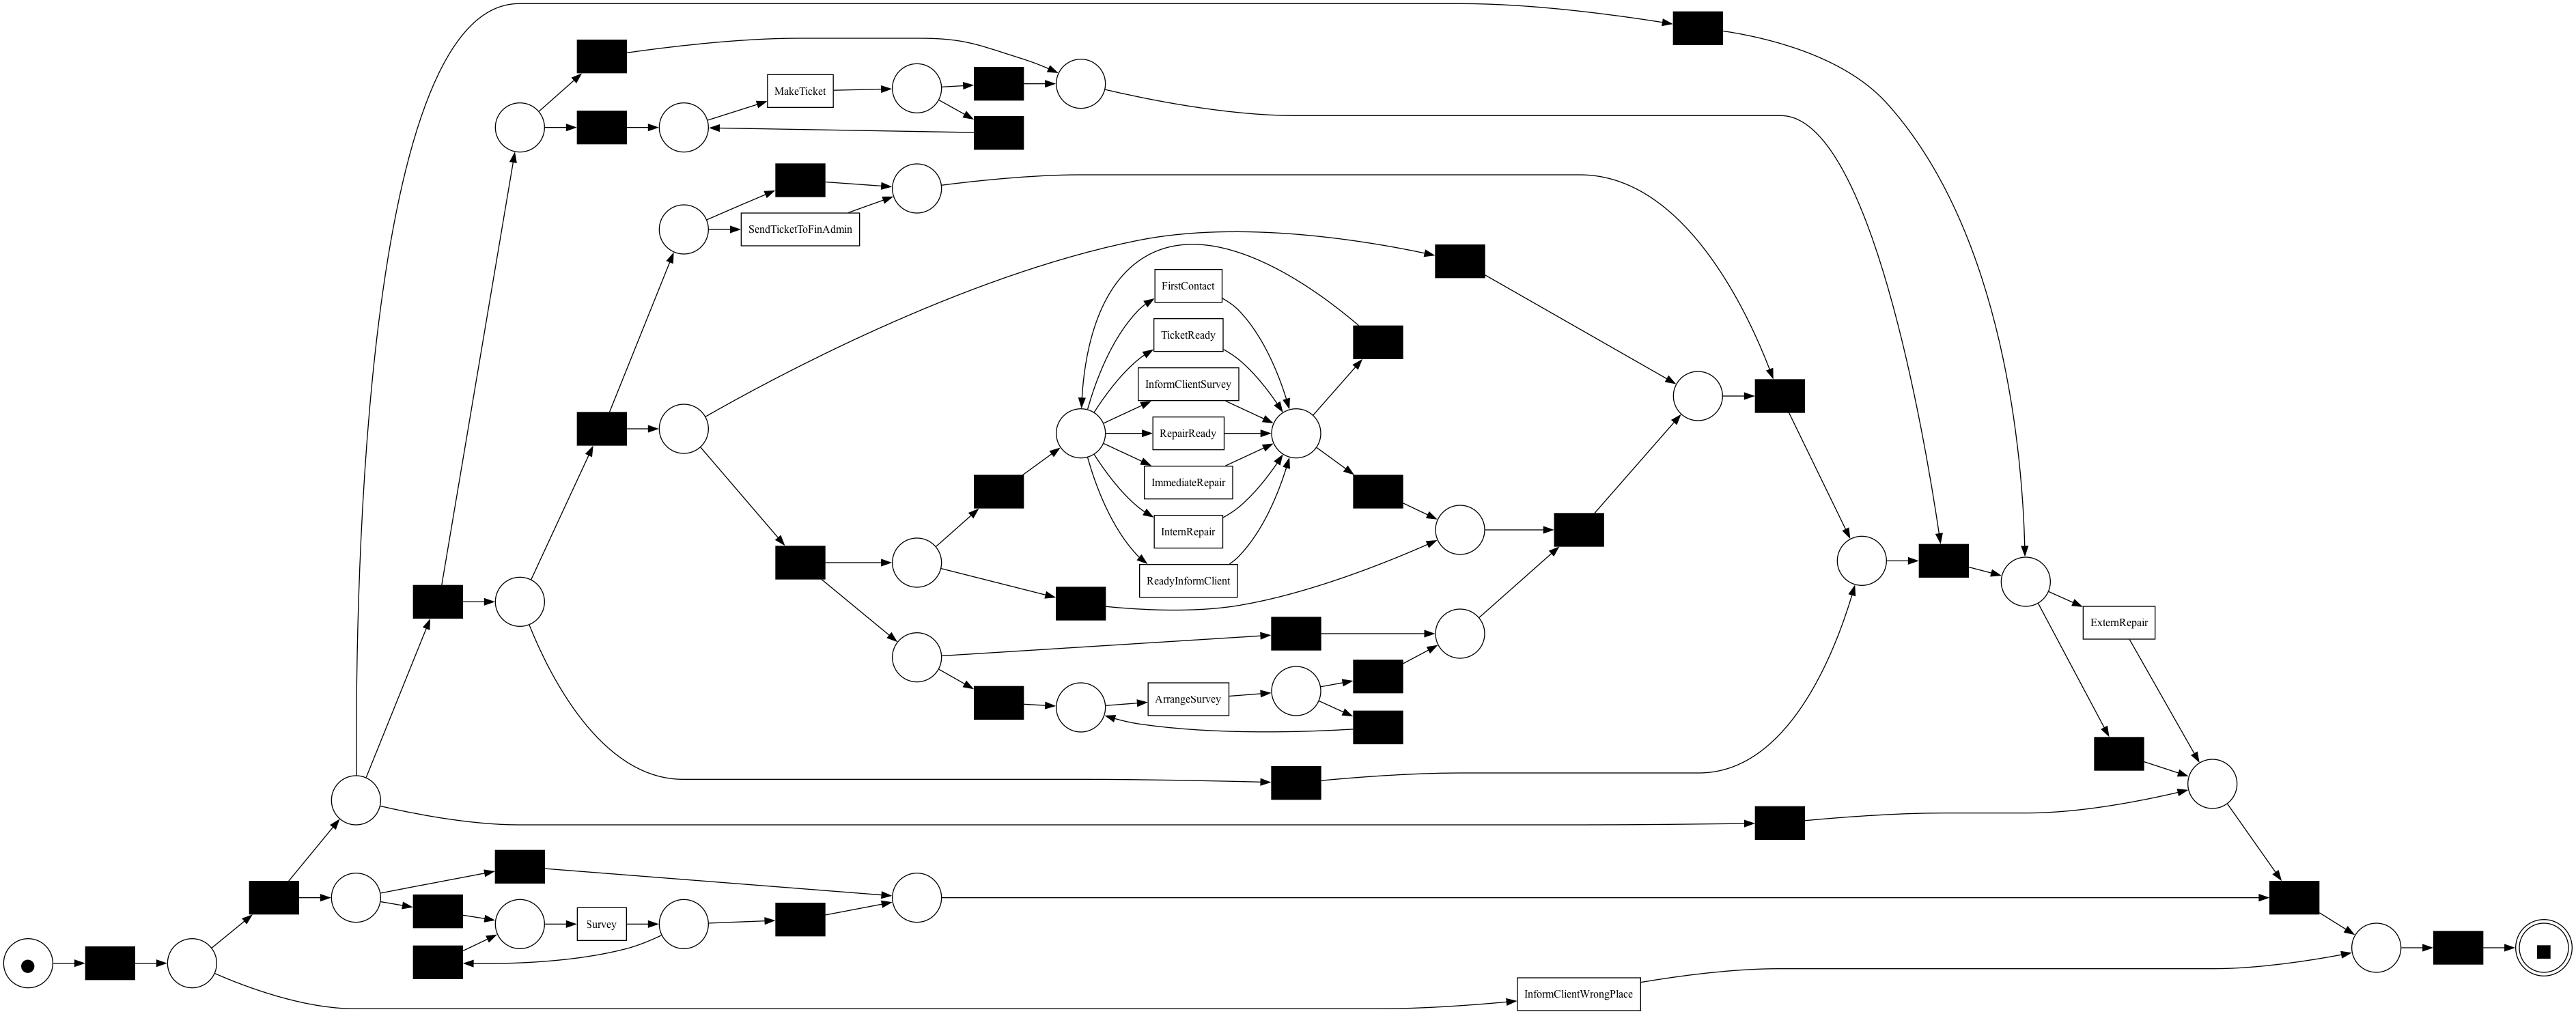

In [55]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as pt_converter
process_tree = inductive_miner.apply(event_log)
net_inductive, initial_marking_inductive, final_marking_inductive = pt_converter.apply(process_tree, variant=pt_converter.Variants.TO_PETRI_NET)
gviz_inductive = pn_visualizer.apply(net_inductive, initial_marking_inductive, final_marking_inductive)
pn_visualizer.view(gviz_inductive)

## DFG(Directly-Follow Graph) 생성

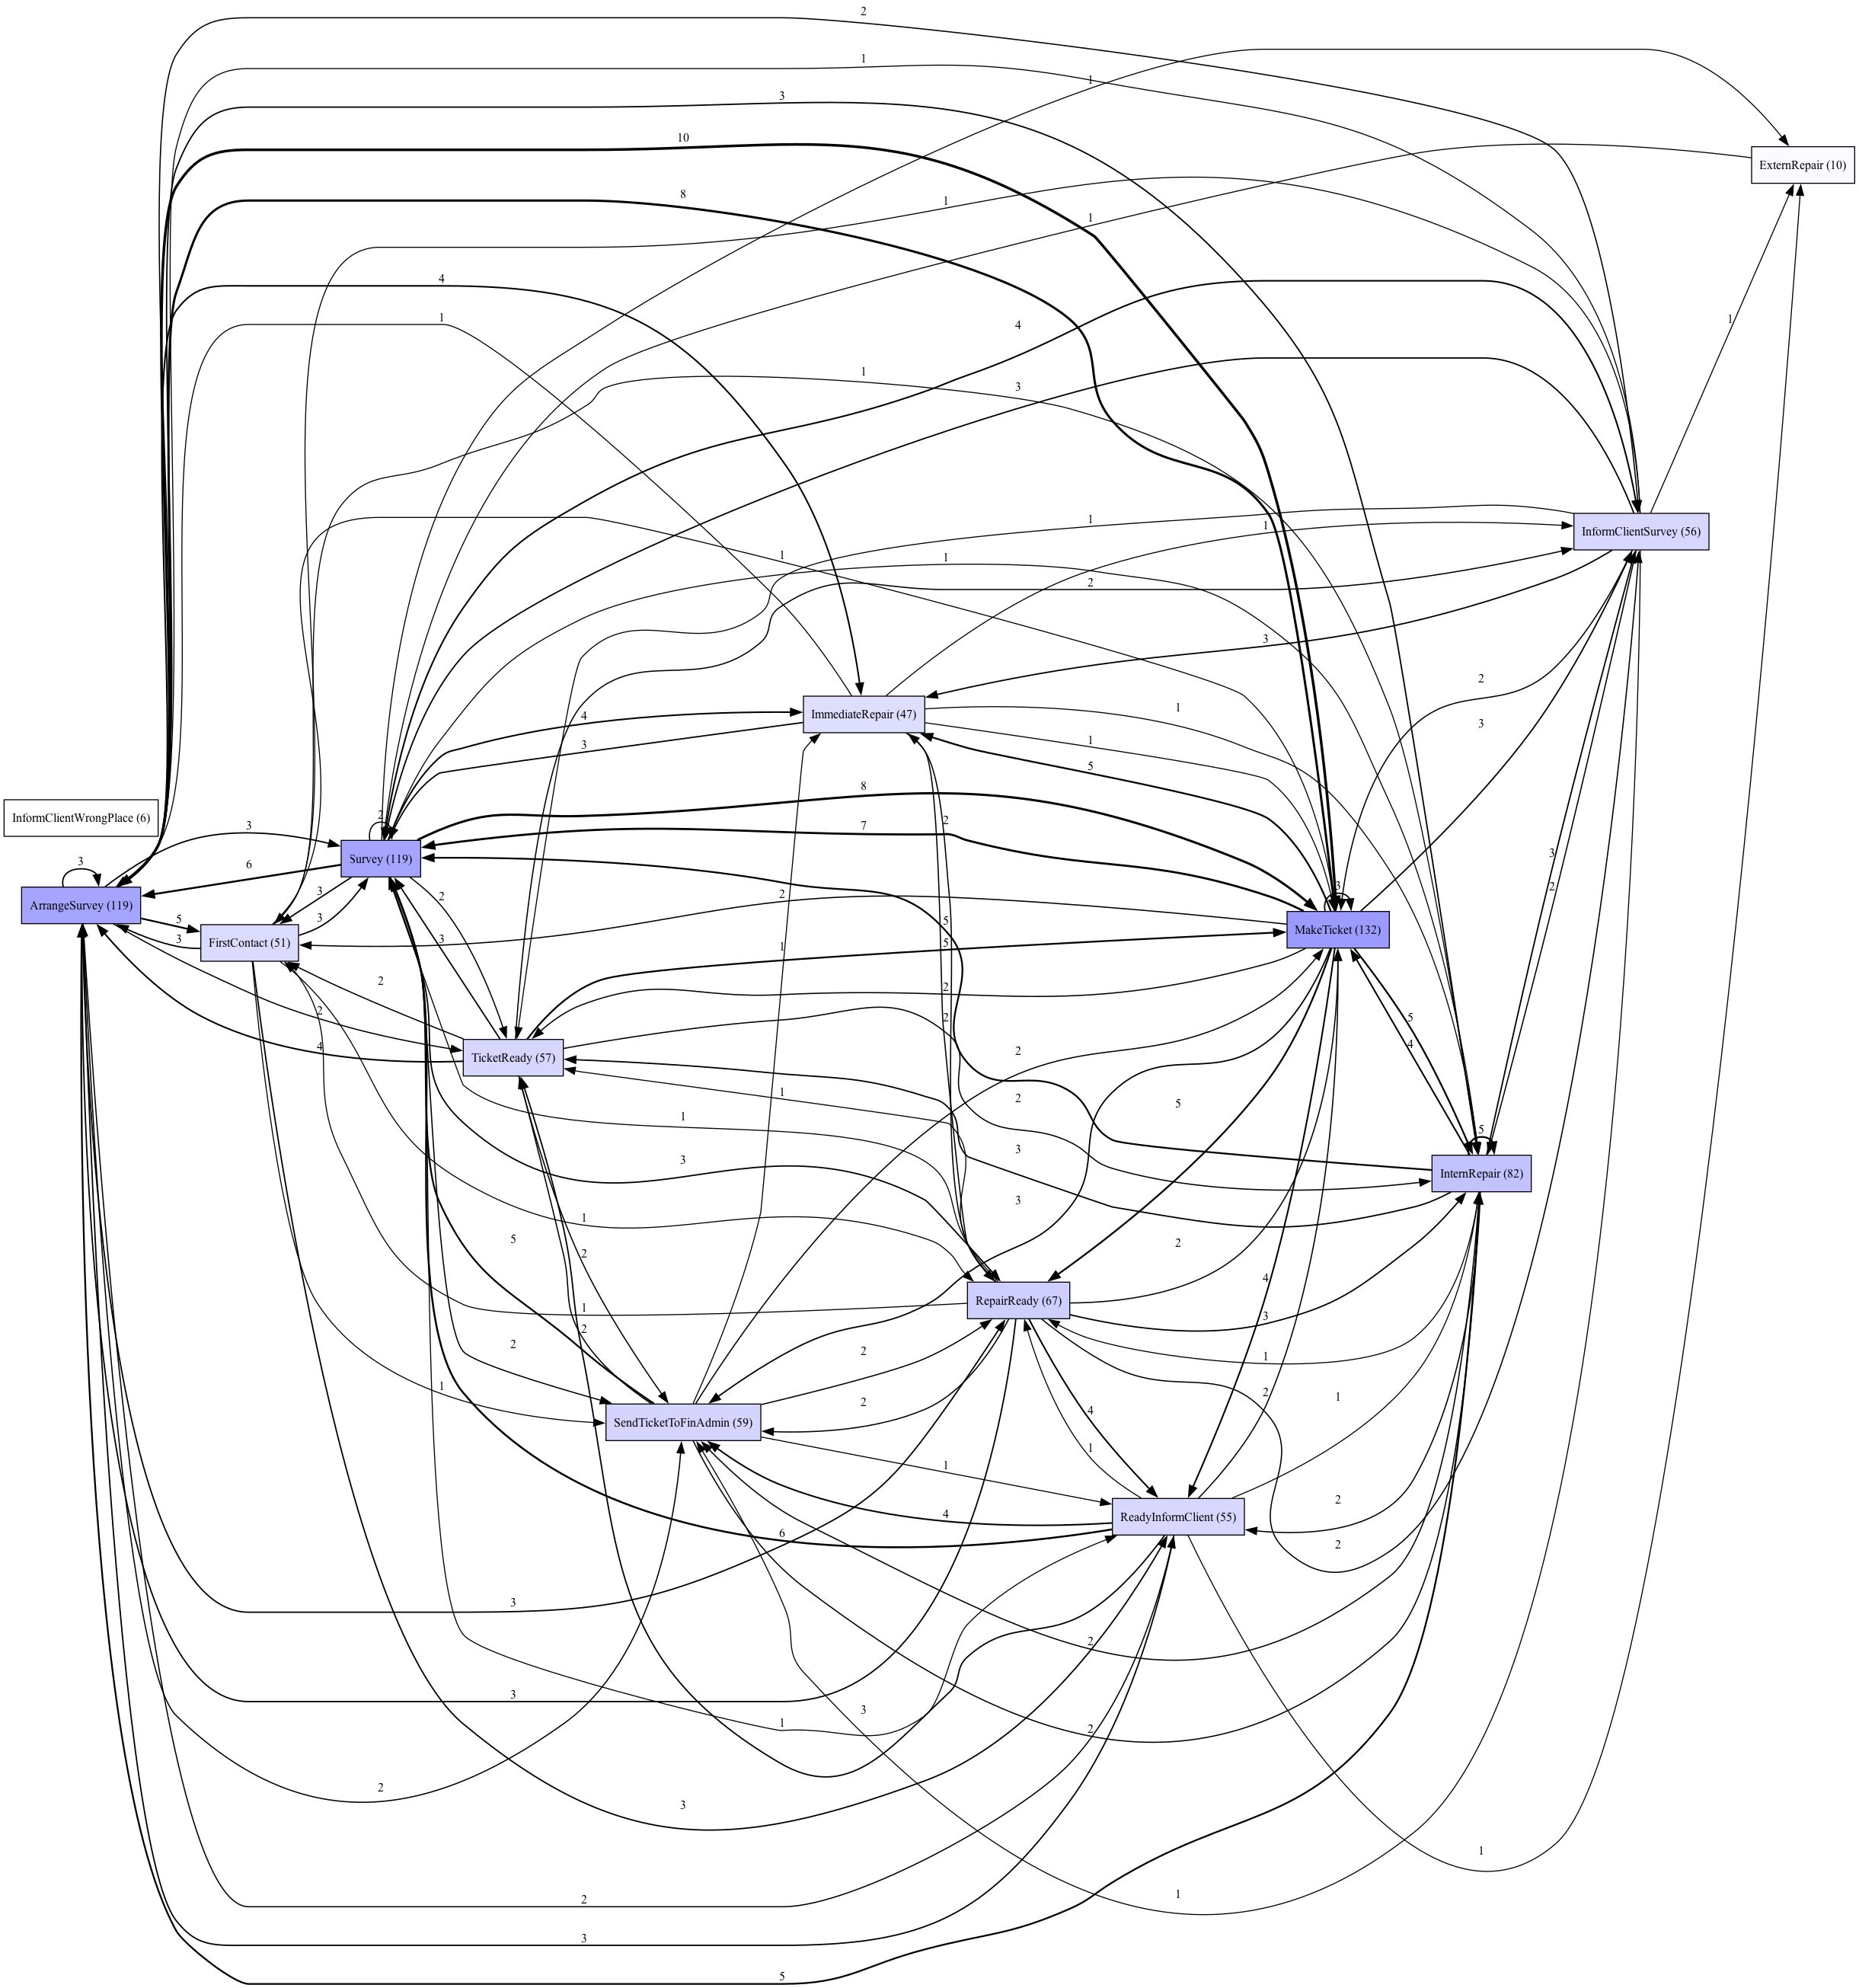

In [56]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualizer

dfg = dfg_discovery.apply(event_log)
gviz = dfg_visualizer.apply(dfg, log=event_log, variant=dfg_visualizer.Variants.FREQUENCY)
dfg_visualizer.view(gviz)

## Conformane Checking (적합도 검증)

In [57]:
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments

aligned_traces = alignments.apply_log(event_log, net, initial_marking, final_marking)
for trace, alignment in zip(event_log, aligned_traces):
    print("trace:", trace)
    print("sequence of move:", alignment)

aligning log, completed variants ::   0%|          | 0/143 [00:00<?, ?it/s]

trace: {'attributes': {'concept:name': 419}, 'events': [{'concept:name': 'InformClientSurvey', 'originator': 'System', 'eventtype': 'complete', 'contact': nan, 'RepairType': nan, 'objectKey': nan, 'RepairInternally': nan, 'EstimatedRepairTime': nan, 'RepairCode': 'nan', 'RepairOK': nan, 'time:timestamp': Timestamp('2020-01-06 11:51:00')}]}
sequence of move: {'alignment': [('InformClientSurvey', '>>'), ('>>', 'Survey')], 'cost': 20000, 'visited_states': 2, 'queued_states': 13, 'traversed_arcs': 13, 'lp_solved': 1, 'fitness': 0.0, 'bwc': 20000}
trace: {'attributes': {'concept:name': 561}, 'events': [{'concept:name': 'ArrangeSurvey', 'originator': 'Monica', 'eventtype': 'complete', 'contact': nan, 'RepairType': nan, 'objectKey': nan, 'RepairInternally': nan, 'EstimatedRepairTime': nan, 'RepairCode': 'nan', 'RepairOK': nan, 'time:timestamp': Timestamp('2020-01-07 13:48:00')}, '..', {'concept:name': 'MakeTicket', 'originator': 'Monica', 'eventtype': 'start', 'contact': nan, 'RepairType': na

# 현재 프로세스의 문제점(병목 현상, 반복 작업 등)을 분석

In [58]:
#반복 작업을 분석하기 위해 빈번하게 발생하는 TaskID를 확인하여 판단
from pm4py.statistics.traces.generic.log.case_statistics import get_variant_statistics
variant_stats = get_variant_statistics(event_log)
variant_stats = sorted(variant_stats, key=lambda x: x['count'], reverse=True)
print("\n자주 발생한 이벤트 시퀀스（반복작업가능성）：")
for stats in variant_stats[:5]:
    print(f"이벤트시퀀스: {stats['variant']}, 발생횟수: {stats['count']}")


자주 발생한 이벤트 시퀀스（반복작업가능성）：
이벤트시퀀스: ('MakeTicket',), 발생횟수: 54
이벤트시퀀스: ('ArrangeSurvey',), 발생횟수: 53
이벤트시퀀스: ('Survey',), 발생횟수: 50
이벤트시퀀스: ('InternRepair',), 발생횟수: 34
이벤트시퀀스: ('RepairReady',), 발생횟수: 32


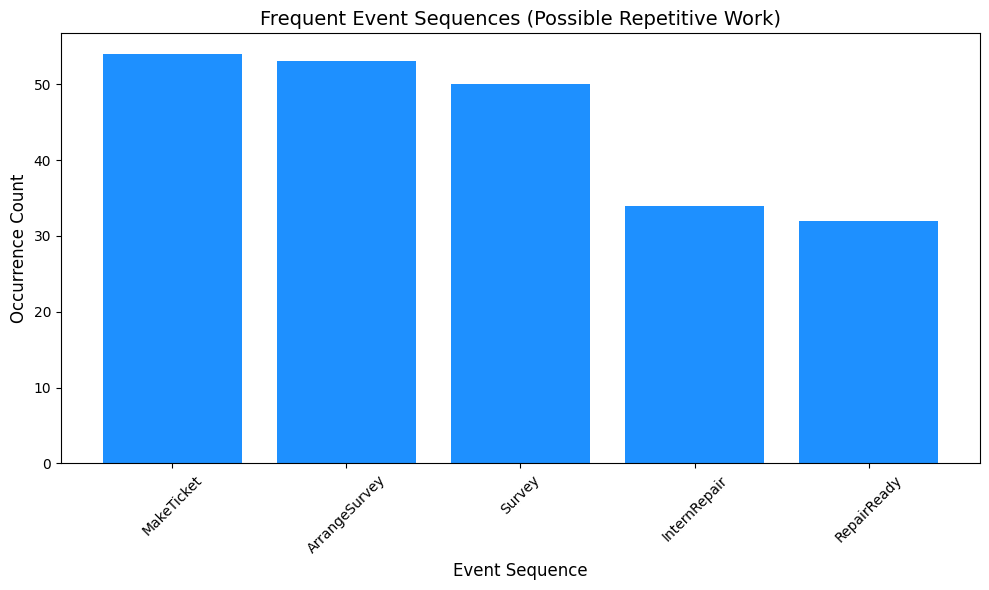

In [24]:
data = {
    'Event Sequence': ['MakeTicket', 'ArrangeSurvey', 'Survey', 'InternRepair', 'RepairReady'],
    'Occurrence Count': [54, 53, 50, 34, 32]
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
plt.bar(df['Event Sequence'], df['Occurrence Count'], color='#1E90FF')

plt.title('Frequent Event Sequences (Possible Repetitive Work)', fontsize=14)
plt.xlabel('Event Sequence', fontsize=12)
plt.ylabel('Occurrence Count', fontsize=12)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [59]:
# 병목현상 분석, 평균 시간이 오래 걸리는 활동을 병목현상으로 활용
sorted_activities = sorted(activity_durations.items(), key=lambda x: x[1], reverse=True)
print("병목현상 가능성（평균 소요시간 내림차순 정렬）：")
for activity, duration in sorted_activities[:5]:
    print(f"활동: {activity}, 평균소요시간: {duration}")

병목현상 가능성（평균 소요시간 내림차순 정렬）：
활동: MakeTicket, 평균소요시간: 132
활동: ArrangeSurvey, 평균소요시간: 119
활동: Survey, 평균소요시간: 119
활동: InternRepair, 평균소요시간: 82
활동: RepairReady, 평균소요시간: 67


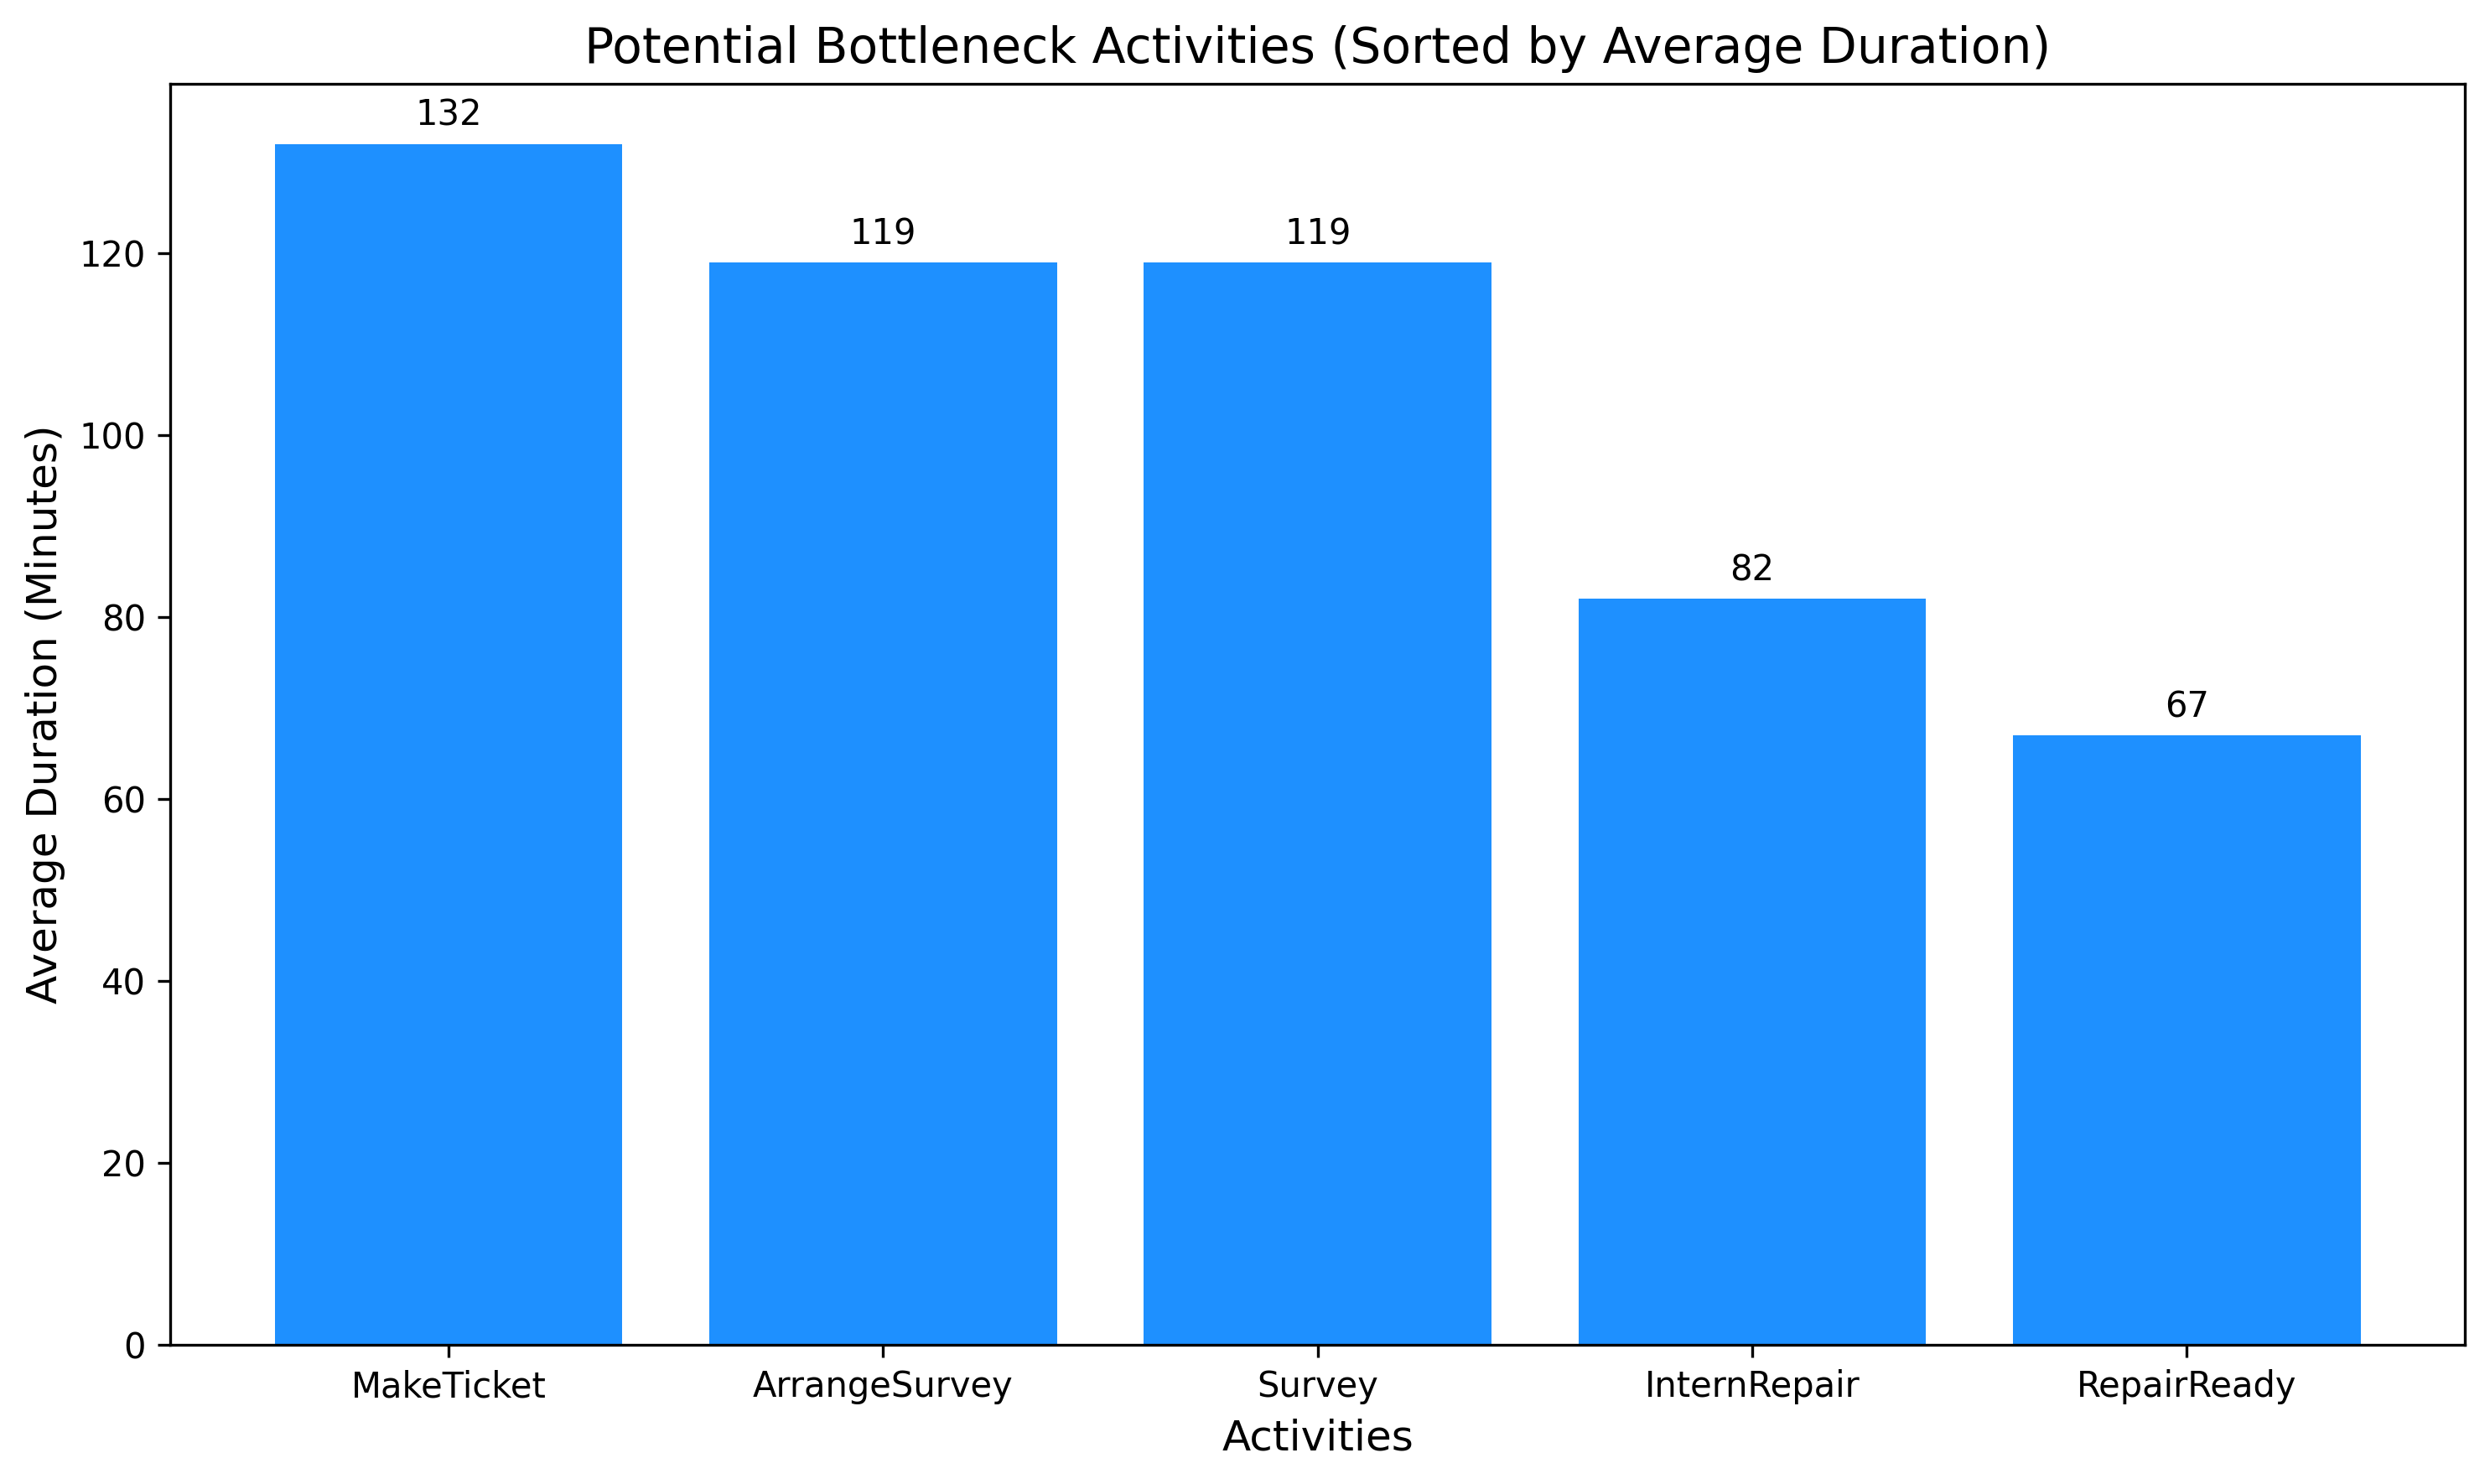

In [42]:
activities = ['MakeTicket', 'ArrangeSurvey', 'Survey', 'InternRepair', 'RepairReady']
durations = [132, 119, 119, 82, 67]

plt.figure(figsize=(10, 6), dpi=300)
plt.bar(activities, durations, color='#1E90FF')

plt.title('Potential Bottleneck Activities (Sorted by Average Duration)', fontsize=14)
plt.xlabel('Activities', fontsize=12)
plt.ylabel('Average Duration (Minutes)', fontsize=12)

for i, v in enumerate(durations):
    plt.text(i, v + 2, str(v), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

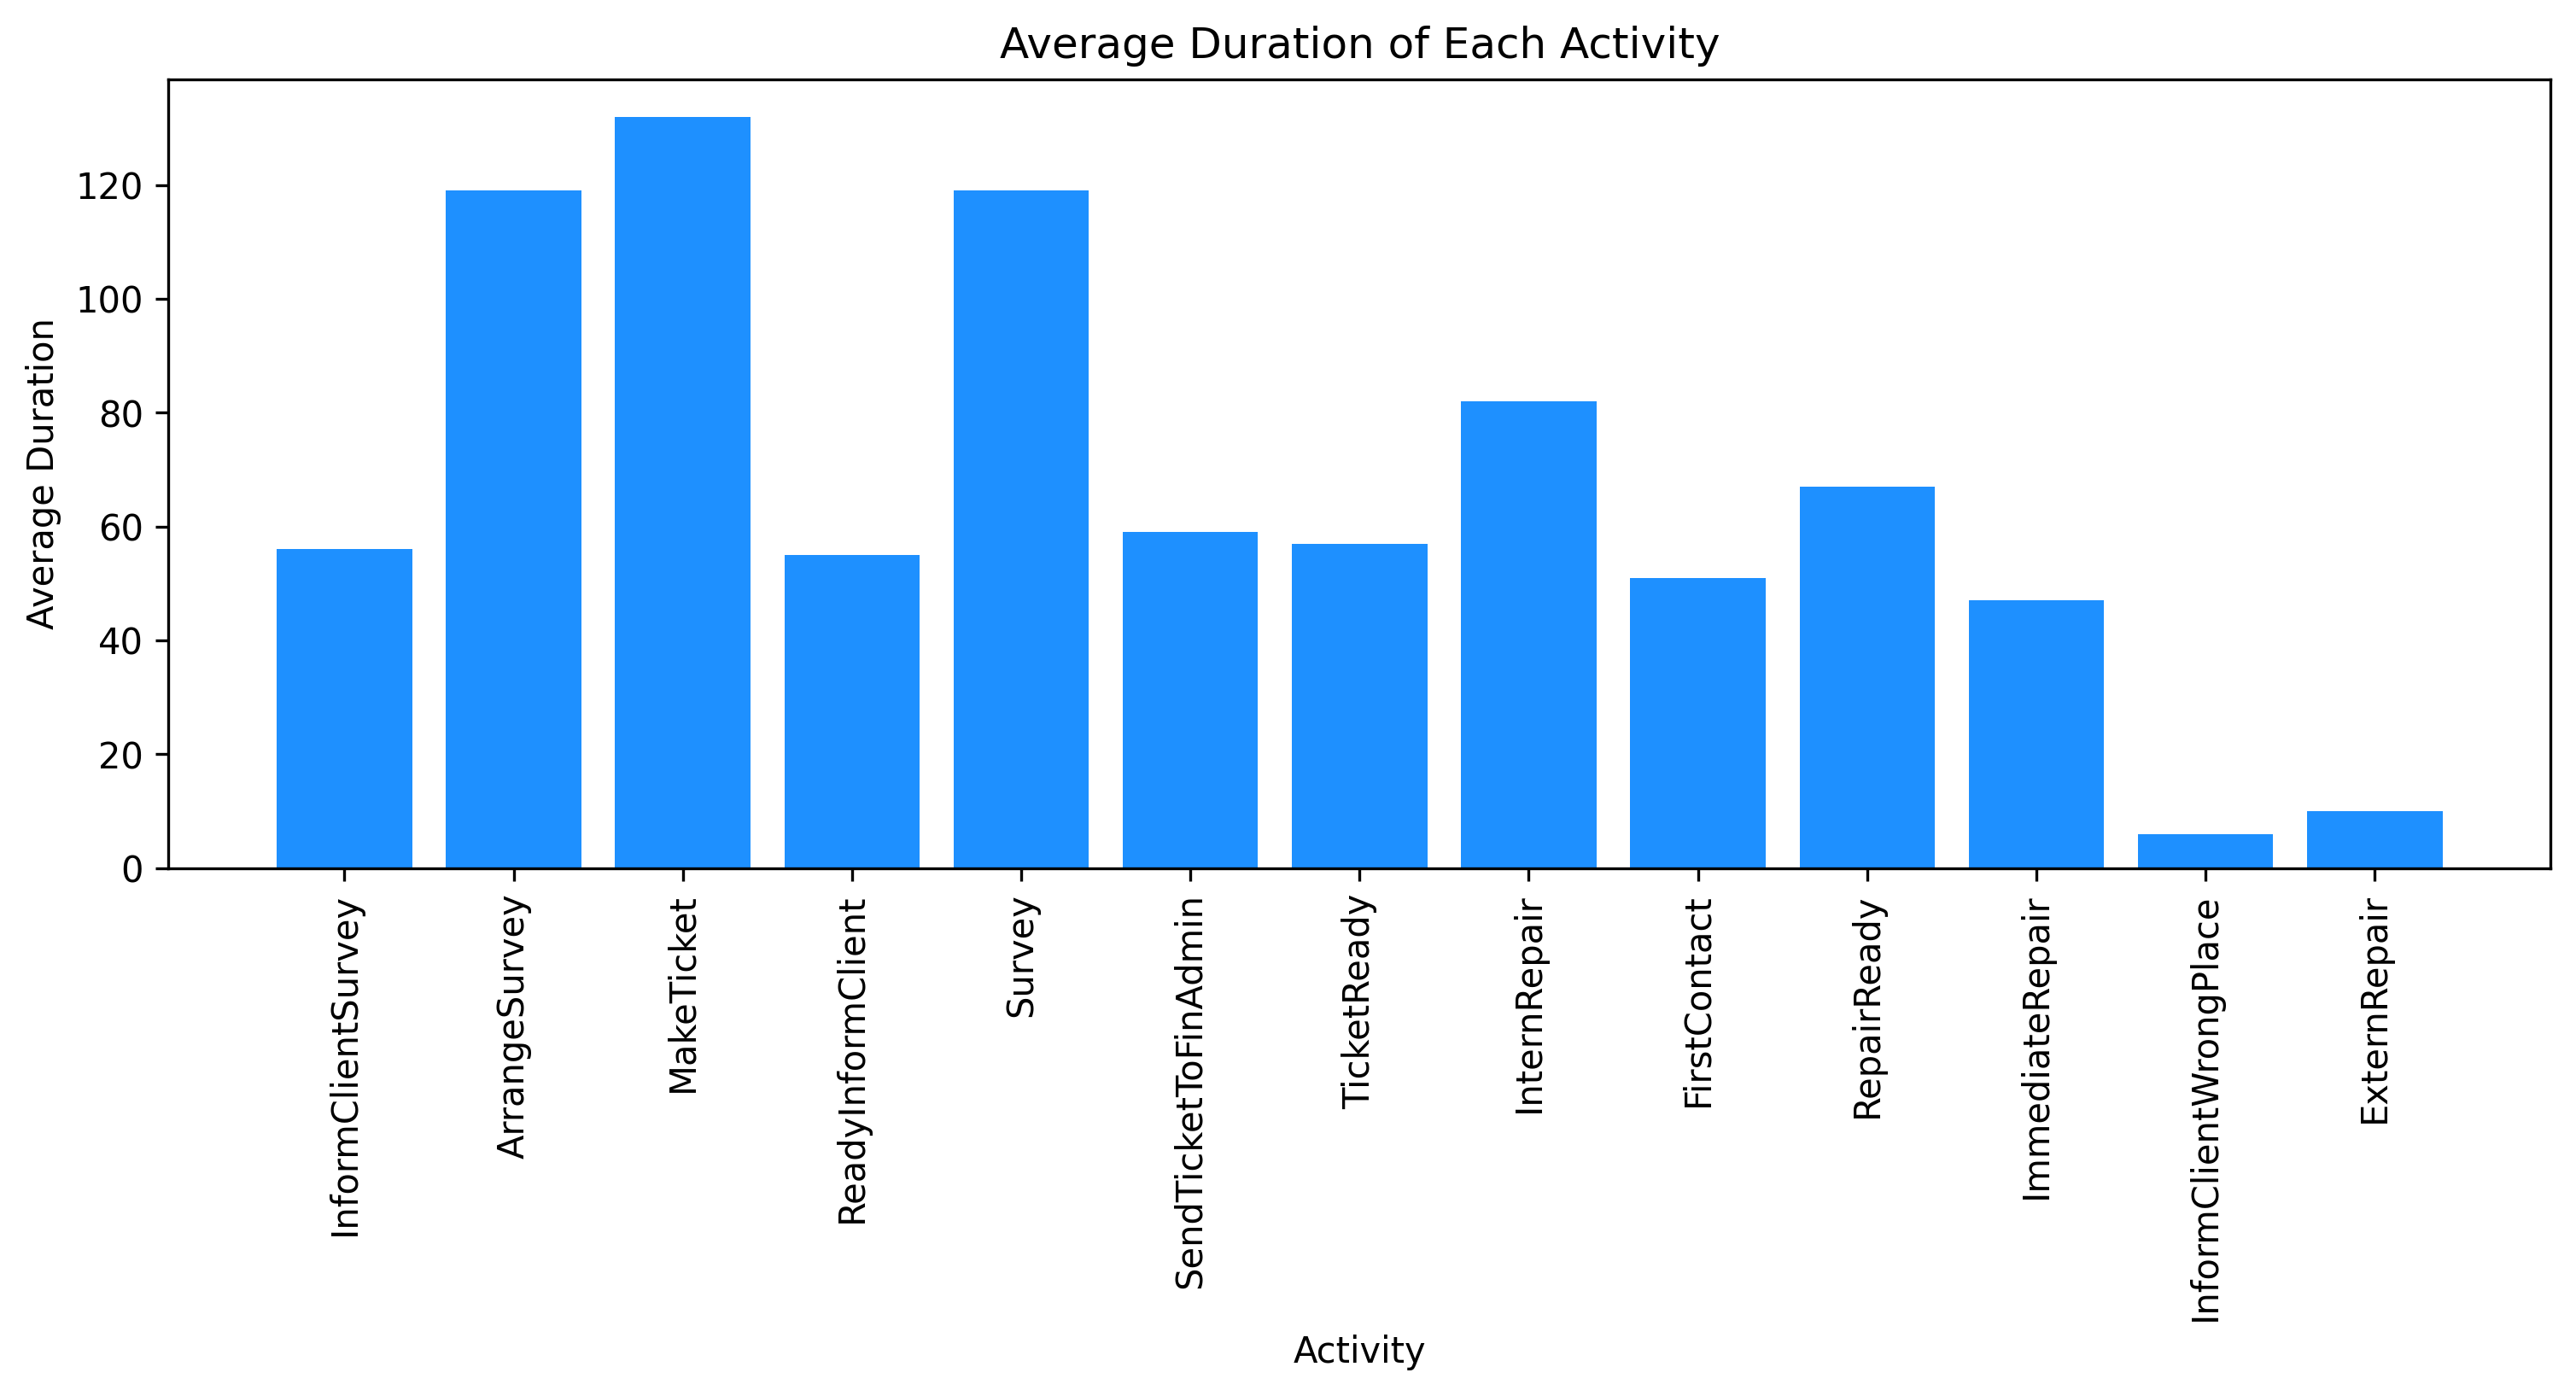

In [34]:
# 각 노드의 평균 소요 시간 계산 
activity_durations = pm4py.stats.get_event_attribute_values(event_log, 'concept:name')

plt.figure(figsize=(12,4), dpi=300)
plt.bar(activity_durations.keys(), activity_durations.values(), color='#1E90FF')
plt.xlabel('Activity')
plt.ylabel('Average Duration')
plt.title('Average Duration of Each Activity')
plt.xticks(rotation=90)
plt.show()


다양한 속성 값에 따른 케이스 평균 소요 시간 분석


다른 값 originator 값들이 케이스 평균 소요 시간에 미치는 영향:
originator 값: System, 케이스 평균 소요시간: 424
originator 값: Monica, 케이스 평균 소요시간: 242
originator 값: Dian, 케이스 평균 소요시간: 209
originator 값: Anne, 케이스 평균 소요시간: 94
originator 값: Cindy, 케이스 평균 소요시간: 53
originator 값: Barbara, 케이스 평균 소요시간: 45
originator 값: John, 케이스 평균 소요시간: 44
originator 값: Edd, 케이스 평균 소요시간: 37
originator 값: Paul, 케이스 평균 소요시간: 37
originator 값: Jacky, 케이스 평균 소요시간: 37
originator 값: Eric, 케이스 평균 소요시간: 17
originator 값: Lex, 케이스 평균 소요시간: 11
originator 값: Nick, 케이스 평균 소요시간: 9
originator 값: Ben, 케이스 평균 소요시간: 9
originator 값: FixIt, 케이스 평균 소요시간: 9
originator 값: DoIt, 케이스 평균 소요시간: 8

다른 값 eventtype 값들이 케이스 평균 소요 시간에 미치는 영향:
eventtype 값: complete, 케이스 평균 소요시간: 734
eventtype 값: start, 케이스 평균 소요시간: 395

다른 값 contact 값들이 케이스 평균 소요 시간에 미치는 영향:
contact 값: nan, 케이스 평균 소요시간: 832
contact 값: Phone, 케이스 평균 소요시간: 36
contact 값: Web, 케이스 평균 소요시간: 24
contact 값: Personal, 케이스 평균 소요시간: 21
contact 값: Letter, 케이스 평균 소요시간: 9

다른 값 RepairType 값들이 케이스 평균 소요 시간에 미치는 영향:
Rep

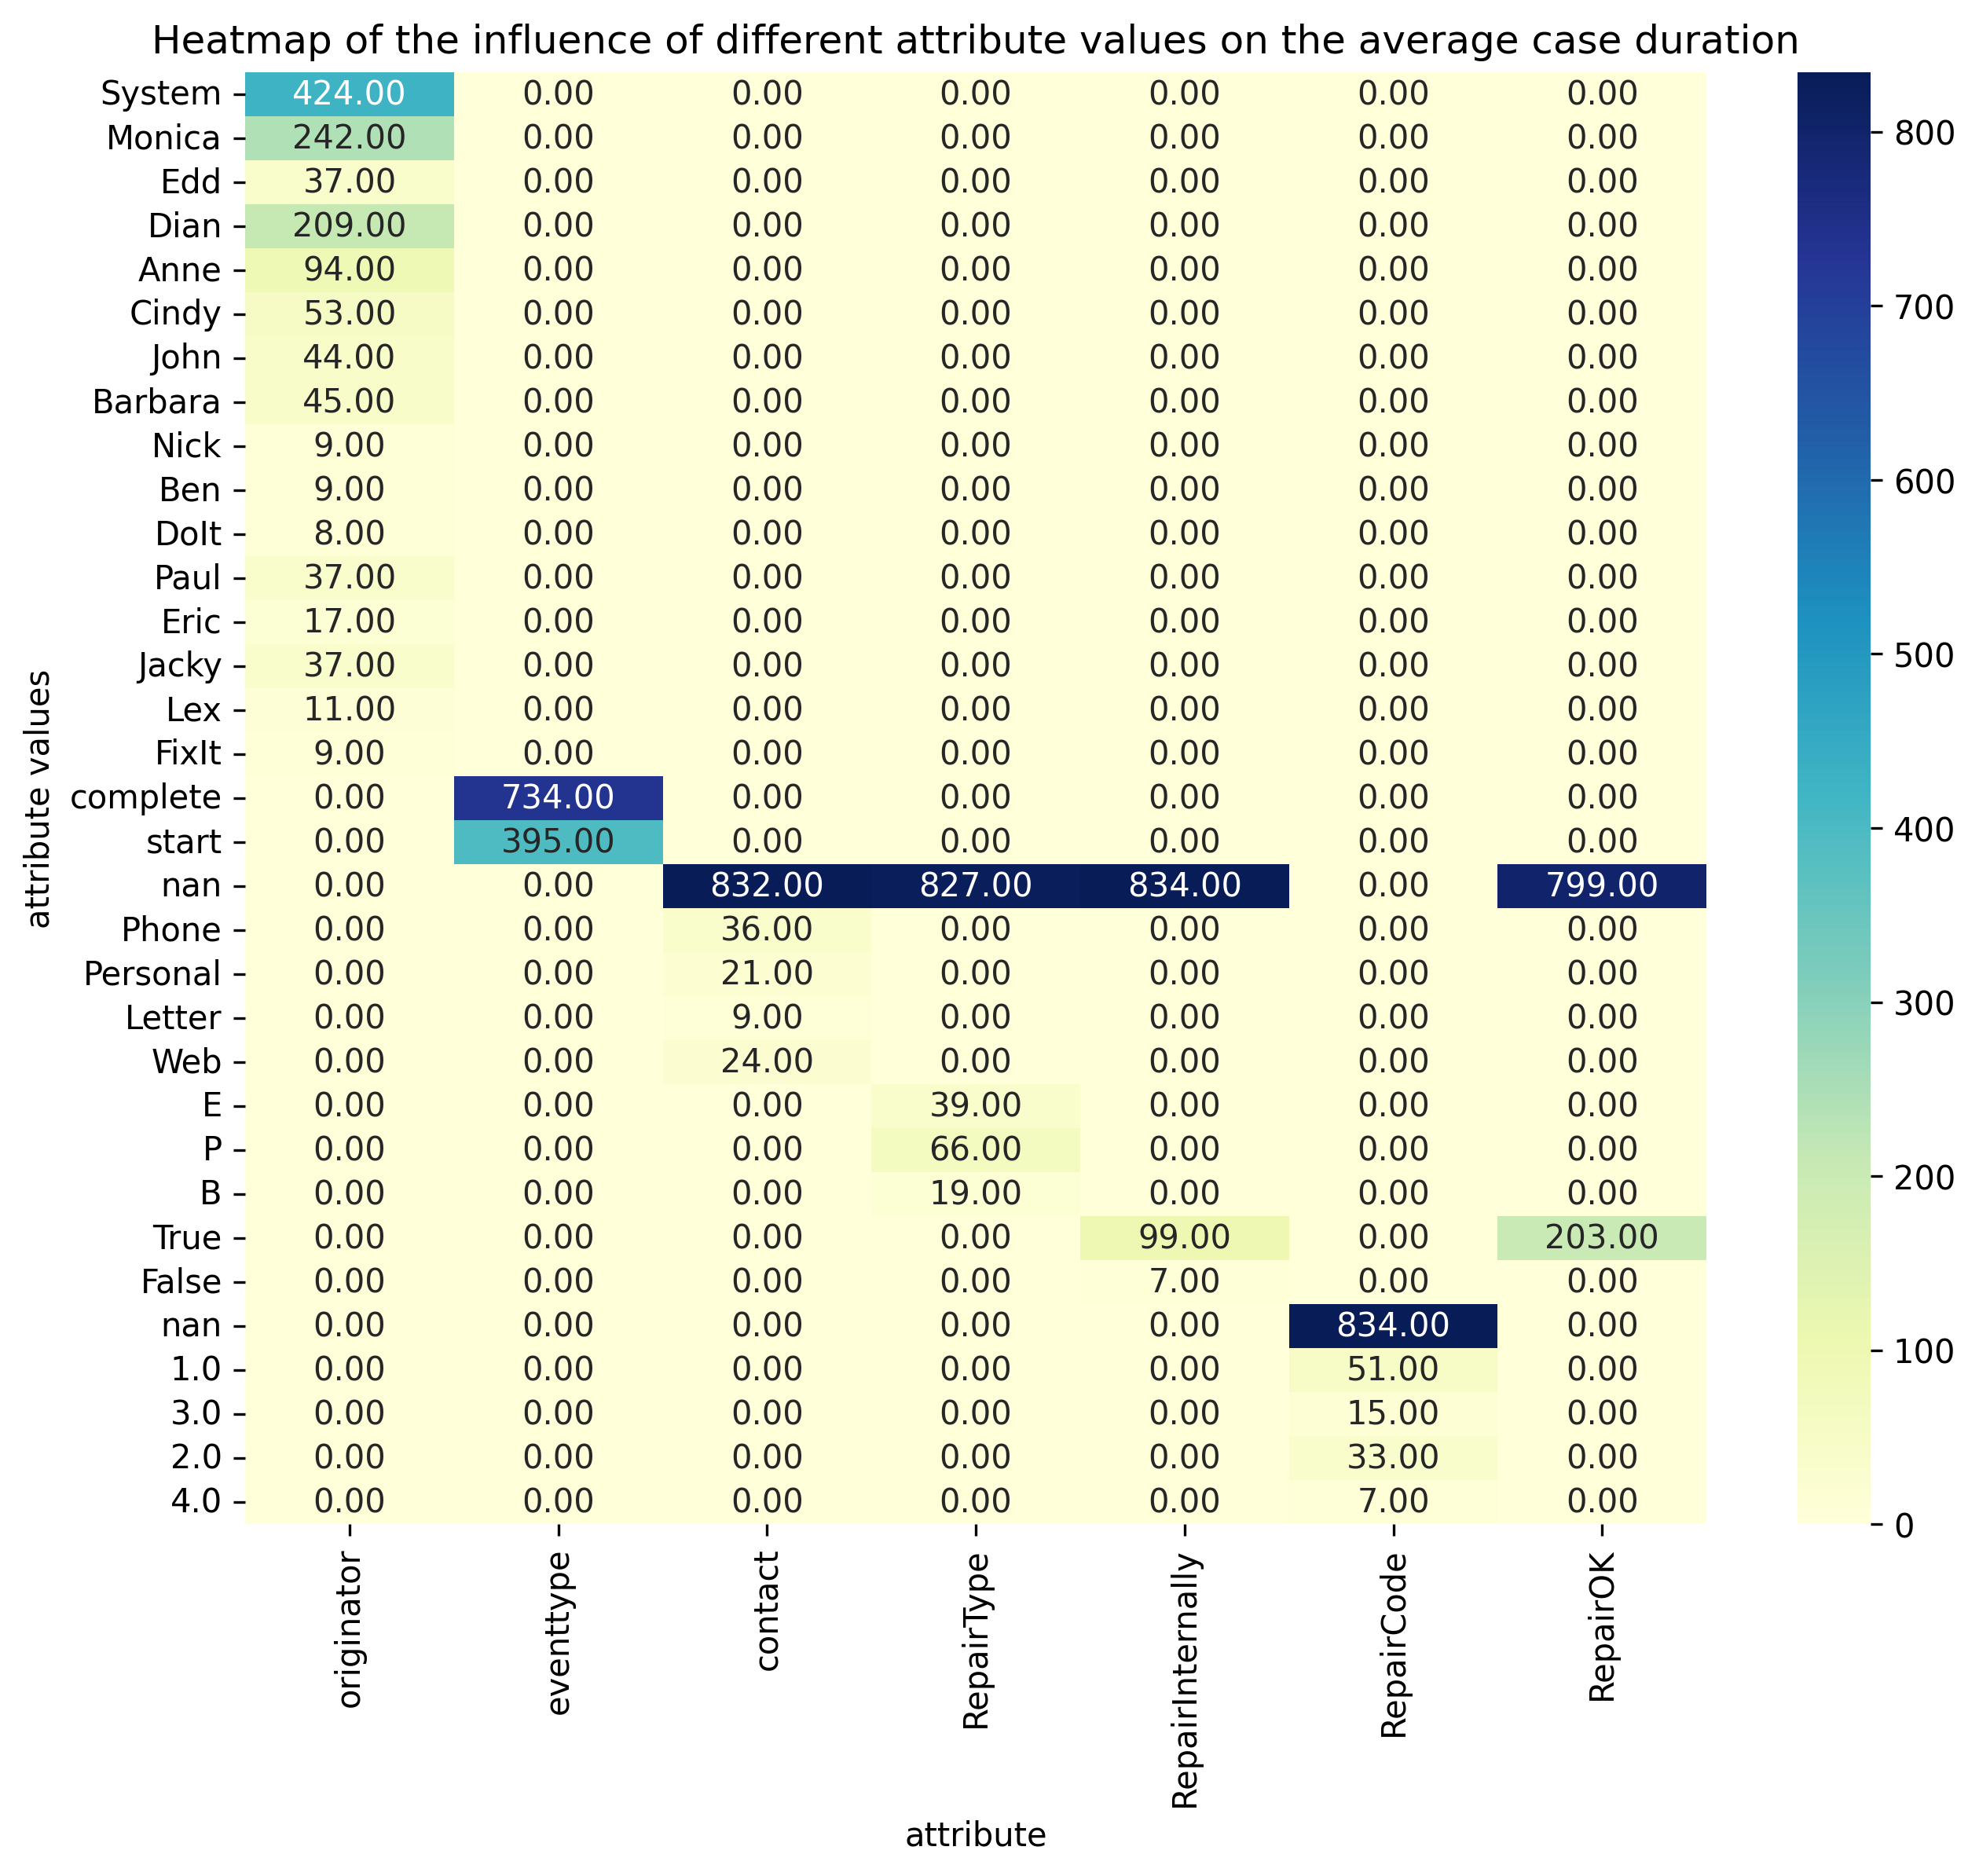

In [60]:
# 케이스 소요 시간에 영향을 미치는 데이터 요소 분석, 다양한 속성 값에 따른 케이스 평균 소요 시간 분석
from pm4py.statistics.attributes.log import get as attributes_get
from pm4py.algo.filtering.log.attributes import attributes_filter
# 프로세스 내 각 이벤트 평균 지속 시간 구하기
parameters = {
    "attribute_key": "concept:name",
    "aggregation_measure": "mean"
}

attributes = ['originator', 'eventtype', 'contact', 'RepairType', 'RepairInternally', 'RepairCode', 'RepairOK']
result_dict = {}
for attr in attributes:
    attr_values = data[attr].unique()
    attr_avg_durations = {}
    for val in attr_values:
        filtered_log = attributes_filter.apply(event_log, [val], parameters={
            attributes_filter.Parameters.ATTRIBUTE_KEY: attr,
            attributes_filter.Parameters.POSITIVE: True
        })
        if filtered_log:
            durations = attributes_get.get_attribute_values(filtered_log, "concept:name", parameters=parameters)
            total_duration = sum(durations.values()) if durations else 0
            attr_avg_durations[val] = total_duration
    if attr_avg_durations:
        result_dict[attr] = attr_avg_durations
        sorted_attr_avg_durations = sorted(attr_avg_durations.items(), key=lambda x: x[1], reverse=True)
        print(f"\n다른 값 {attr} 값들이 케이스 평균 소요 시간에 미치는 영향:")
        for val, duration in sorted_attr_avg_durations:
            print(f"{attr} 값: {val}, 케이스 평균 소요시간: {duration}")
df111 = pd.DataFrame(result_dict)
# 결측값 처리
df111 = df111.fillna(0)

# 히트맵
plt.figure(figsize=(10, 8),dpi=300)
sns.heatmap(df111, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Heatmap of the influence of different attribute values on the average case duration")
plt.xlabel("attribute")
plt.ylabel("attribute values")
plt.savefig("heatmap.png")
plt.show()